# Import library and function

In [7]:
import pandas as pd
import numpy as np
import datetime as dt
import scipy as sp
import statsmodels.api as sm
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FuncFormatter 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [8]:
pd.set_option('display.max_rows', 10)
sns.set(font_scale=1.4)

# Read the estimated baseline & AC model coefficient

In [9]:
# estimated baseline
baseline_2017 = pd.read_csv('https://raw.githubusercontent.com/pornpra/ton/master/estimated_baseline_2017.csv', index_col='DateTime',parse_dates=True)
baseline_2018 = pd.read_csv('https://raw.githubusercontent.com/pornpra/ton/master/estimated_baseline_2018.csv', index_col='DateTime',parse_dates=True)
baseline = pd.concat([baseline_2017,baseline_2018])
baseline = baseline.reset_index()

# AC model coefficient
coeff_ac3 = pd.read_csv('https://raw.githubusercontent.com/pornpra/ton/master/environment_coefficient.csv')

# Define environment

In [10]:
class AC3():
    def __init__(self, pA, Tupper, Tlower):
        self.pA = pA  # Cooling ability
        AC3.Amb = baseline['Ambient_temp'][0]
        self.status = 0
        self.temp_set = 0.0
        self.T = 25.0
        self.w = 1
        self.pfan = 0.40
        self.n = 7.58/2.5  # Coefficient of performance 
        self.delta = 0
        self.beta = 0.001  
        self.pmax = baseline['Baseline'].max()
        self.pmin = baseline['Baseline'].min()

        ###### comfort temperature
        self.Tupper = Tupper 
        self.Tlower = Tlower 
        
        if self.Tupper < self.Tlower:
            a = self.Tupper
            b = self.Tlower
            self.Tupper = b
            self.Tlower = a
            
        elif self.Tlower == self.Tupper:
            self.Tupper = self.Tupper+1
            self.Tlower = self.Tlower-1
            
        else:
            self.Tupper = self.Tupper
            self.Tlower = self.Tlower

        AC3.Baseline = 0

        self.observation_space = 26
        self.action_space = [0, 1, -1]
        self.action_space_n = len(self.action_space)


    def On(self):
        if self.status == 0:
            self.status = 1
            self.T_cmd = 0

    def Off(self):
        if self.status == 1:
            self.status = 0
            self.T_cmd = 0

    def getComfort(self):
        return self.Tupper, self.Tlower

    def getT(self):
        return self.T.round(0)
    
    def getT_continuous(self):
        return self.T
    
    def getTempset(self):
        return int(self.temp_set)

    def getAmb(self):
        return AC3.Amb

    def getTroom(attribute, room_temp_value):
        AC3.Troom = room_temp_value
        return AC3.Troom

    def getP(self):
        return ((self.pA*self.w/self.n) + ((1-self.w)*self.pfan))*self.status
    
    def get_on_off(self):
        return self.status

    def setT(self, temp):
        self.temp_set = temp

    ############## Start Action ############

    def increaseT(self):
        self.temp_set = self.temp_set + self.action_space[0]

    def noadjustT(self):
        self.temp_set = self.temp_set + self.action_space[1]

    def decreaseT(self):
        self.temp_set = self.temp_set + self.action_space[2]

    ############## End Action ############


    def getbaseline(attribute, value_baseline):
        AC3.Baseline = value_baseline
        return AC3.Baseline
    
    def NextAmb(attribute, value_ambient):
        AC3.Amb = value_ambient
        return AC3.Amb
            
    def NextT(self):
        
         ### limit setpoint temperature  ### 
        
        if self.temp_set >= 30: 
            self.temp_set = 30
        elif self.temp_set <= 16: 
            self.temp_set = 16
        else:
            self.temp_set = self.temp_set 
        
        self.T = (coeff_ac3['Coefficient'][0] * self.T) + (coeff_ac3['Coefficient'][1] * AC3.Amb) + (coeff_ac3['Coefficient'][2] * self.w) + coeff_ac3['Coefficient'][3]
        
        if self.T > (self.temp_set + self.delta):
            self.w = 1*self.status
        elif self.T < (self.temp_set - self.delta):
            self.w = 0*self.status
        else:
            self.w = self.w*self.status
            
    def step(self, action):
    
        if self.action_space[action] == self.action_space[0]:
            self.temp_set += self.action_space[0]
            
        elif self.action_space[action] == self.action_space[1]:
            self.temp_set += self.action_space[1]

        elif self.action_space[action] == self.action_space[2]:
            self.temp_set += self.action_space[2]
        else:
            self.temp_set = self.temp_set
            
        ### limit setpoint temperature  ### 
        
        if self.temp_set >= 30: 
            self.temp_set = 30
        elif self.temp_set <= 16: 
            self.temp_set = 16
        else:
            self.temp_set = self.temp_set 
            
        self.T = (coeff_ac3['Coefficient'][0] * self.T) + (coeff_ac3['Coefficient'][1] * AC3.Amb) + (coeff_ac3['Coefficient'][2] * self.w) + coeff_ac3['Coefficient'][3]

        if self.T > (self.temp_set + self.delta):
            self.w = 1*self.status
        elif self.T < (self.temp_set - self.delta):
            self.w = 0*self.status
        else:
            self.w = self.w*self.status
            
        ##### define Q-table #####
        
        if (self.status == 1) and (self.w == 0) and int(self.T) <= 20:
            nextState = 0
        elif (self.status == 1) and (self.w == 0) and int(self.T) == 21:
            nextState = 1
        elif (self.status == 1) and (self.w == 0) and int(self.T) == 22:
            nextState = 2
        elif (self.status == 1) and (self.w == 0) and int(self.T) == 23:
            nextState = 3
        elif (self.status == 1) and (self.w == 0) and int(self.T) == 24:
            nextState = 4
        elif (self.status == 1) and (self.w == 0) and int(self.T) == 25:
            nextState = 5
        elif (self.status == 1) and (self.w == 0) and int(self.T) == 26:
            nextState = 6
        elif (self.status == 1) and (self.w == 0) and int(self.T) == 27:
            nextState = 7
        elif (self.status == 1) and (self.w == 0) and int(self.T) == 28:
            nextState = 8
        elif (self.status == 1) and (self.w == 0) and int(self.T) == 29:
            nextState = 9
        elif (self.status == 1) and (self.w == 0) and int(self.T) == 30:
            nextState = 10
        elif (self.status == 1) and (self.w == 0) and int(self.T) == 31:
            nextState = 11
        elif (self.status == 1) and (self.w == 0) and int(self.T) >= 32:
            nextState = 12
            
        elif (self.status == 1) and (self.w == 1) and int(self.T) <= 20:
            nextState = 13
        elif (self.status == 1) and (self.w == 1) and int(self.T) == 21:
            nextState = 14
        elif (self.status == 1) and (self.w == 1) and int(self.T) == 22:
            nextState = 15
        elif (self.status == 1) and (self.w == 1) and int(self.T) == 23:
            nextState = 16
        elif (self.status == 1) and (self.w == 1) and int(self.T) == 24:
            nextState = 17
        elif (self.status == 1) and (self.w == 1) and int(self.T) == 25:
            nextState = 18
        elif (self.status == 1) and (self.w == 1) and int(self.T) == 26:
            nextState = 19
        elif (self.status == 1) and (self.w == 1) and int(self.T) == 27:
            nextState = 20
        elif (self.status == 1) and (self.w == 1) and int(self.T) == 28:
            nextState = 21
        elif (self.status == 1) and (self.w == 1) and int(self.T) == 29:
            nextState = 22
        elif (self.status == 1) and (self.w == 1) and int(self.T) == 30:
            nextState = 23
        elif (self.status == 1) and (self.w == 1) and int(self.T) == 31:
            nextState = 24
        elif (self.status == 1) and (self.w == 1) and int(self.T) >= 32:
            nextState = 25
        else:
            nextState = 25

        # receive reward
        
        reward_power = AC3.Baseline - (((self.pA*self.w/self.n) + ((1-self.w)*self.pfan))*self.status)
        reward_power_normalize = (reward_power - self.pmin)/(self.pmax - self.pmin)
        
        if self.Tlower < self.T < self.Tupper:
            reward_temp = 0
            
        else:
            reward_temp = (min(abs(self.T-self.Tupper),abs(self.T-self.Tlower)))**2
        
        reward_temp_normalize = reward_temp/(self.Tupper-self.Tlower)
        
        reward = (self.beta)*(reward_power_normalize)-(1-self.beta)*(reward_temp_normalize)
        
        return nextState, reward
    

    def reset(self):
        return 19

# Define agent

In [11]:
class Agent:
    def __init__(self, state_size, action_size):
        self.EPSILON = 1
        self.ALPHA = 0.03
        self.GAMMA = .99
        self.num_action = action_size
        self.Q = np.zeros([state_size, self.num_action])

    def chooseAction(self, state):
        if np.random.binomial(1, self.EPSILON) == 1:
            return np.random.choice(self.num_action)
        else:
            return np.argmax(self.Q[state,:])
    
    def learn(self, state, action, reward, nextState):
        self.Q[state, action] += self.ALPHA*(reward + self.GAMMA*np.max(self.Q[nextState,:]) - self.Q[state, action])

    def reduceExploration(self, i):
            self.EPSILON /= i+1

# Run simulation 

In [12]:
t0 = time.time()

if __name__ == "__main__":
    
    env = AC3(7.58,27,23)

    num_episodes = baseline['Episode'].max()

    
    agent = Agent(env.observation_space, env.action_space_n)

    total_reward = np.zeros(num_episodes+1)
    
    Tupper = np.array(env.getComfort())[0]
    Tlower = np.array(env.getComfort())[1]

    sumP = 0
    sumBaseline = 0
    
    Count_list, Amb_list = [], []
    Tset_list = []
    T_list = []
    T_list_continuous = []
    P_list = []
    Baseline_list = []
    EP_list = []
    Action_list = []
       
    env.Off()
    env.setT(26.0) 
    
    
    for i in range(1,num_episodes+1,1):
        state = env.reset()
        eps = baseline.loc[(baseline['Episode'] == i)]
        print(np.mean(eps['Episode'].values))
        num_steps = eps.shape[0]
        
        for j in range(num_steps+1):
            
            if baseline['Baseline'][j] > 0:
                env.On()
                
                if j%15 == 0:
                    env.getbaseline(baseline['Baseline'][j])
                    action = agent.chooseAction(state)
                    nextState, reward = env.step(action)
                    agent.learn(state, action, reward, nextState)
                    total_reward[i] += reward
                    print(reward)
                    state = nextState
                    Baseline_list.append(baseline['Baseline'][j])
                    Tset_list.append(env.getTempset())
                    T_list.append(env.getT())
                    T_list_continuous.append(env.getT_continuous())
                    P_list.append(env.getP())
                    Count_list.append(j)
                    Amb_list.append(env.getAmb())
                    EP_list.append(np.mean(eps['Episode'].values))
                    Action_list.append(action)               
                    
                else:
                    action = action
                    Baseline_list.append(baseline['Baseline'][j])
                    Tset_list.append(env.getTempset())
                    T_list.append(env.getT())
                    T_list_continuous.append(env.getT_continuous())
                    P_list.append(env.getP())
                    Count_list.append(j)
                    Amb_list.append(env.getAmb())
                    Action_list.append(action)
                    EP_list.append(np.mean(eps['Episode'].values))
                    env.NextT()  
                    
            else:             
                env.Off()

            env.NextAmb(baseline['Ambient_temp'][j])
            
            if j == num_steps:
                agent.reduceExploration(i)
                break
            
        if i == num_episodes:
            print("End of episode!")
            df = pd.DataFrame(np.column_stack([Count_list, Tset_list, T_list, P_list, EP_list, Action_list, Baseline_list, T_list_continuous, Amb_list]), columns=['Count','Setpoint', 'T', 'P','Episode','Action','Baseline','T_continuous','Ta'])
            df_performance = df.loc[(df['Episode'] > 12)]
            
t1 = time.time()
time = (t1-t0)/60
print("Simulation time = {:.2f} minutes".format(time))

1.0
0.00012186035170658747
0.00012186035170658747
0.00012186035170658747
-0.0006394312890429326
-0.00044531087489157946
-0.00044531087489157946
0.0003159807658579405
0.0003159807658579405
0.0003435854182634154
-0.013962101378057007
-0.13252333492273743
-0.32876075196404475
-0.5651592182852072
-0.8116258600194171
-1.0927909318957372
-1.3905313057318638
-1.6459444005497759
-1.8999136627507383
-0.9236629927644537
-0.24998064974862494
0.0006500525399988068
-0.11088081878150546
-0.455764771613723
-0.9320739898823075
-1.476445561035395
-1.9984966765585512
-1.0077453496915778
-1.6412165614883805
-0.9927031372227569
-1.6602141098034477
-2.074849215608953
-0.9022799976888372
-0.21561677664559228
-0.19396803636189225
-0.2597895923845239
-0.7205816748182209
-0.9235277143062363
-0.22224615100688053
-0.27175380104681746
-0.00016408745892378452
-0.00014383663000406963
0.0006174550107454504
-0.00014383663000406963
-0.00014383663000406963
0.0006134997018999448
0.0006134997018999448
-0.0001976630591779

-5.059817119948588
-5.009286466543544
-4.992897057144809
-4.978135619923561
-5.001203965764537
-5.042219667264952
-5.111384676619089
-5.092619080684981
-5.024256437538576
-4.9813566251081935
-4.9048978747098815
-4.762239613910985
-4.742778201960934
-4.716070139176507
-4.6706915107888864
-4.5998159602674935
-4.5435455874217325
-4.573977760947723
-4.622240758283299
-4.662578081630984
-4.695528675977831
-4.729996113101289
-4.7533614509703135
-4.768838715933192
-4.784868774100307
-4.803941647550136
-3.949825197995407
-4.131380771550874
-4.280542072991633
-4.40298428140521
-4.504220159833278
-4.583514453754747
-3.7514277830143046
-3.96253612624909
-4.147708821833282
-4.301457386308136
-4.415715309350445
-4.501962546253409
-4.692731816822227
-4.847388346585307
-5.036490144735545
-5.241055618914747
-5.39883627859807
-5.538305506156252
-5.643059350225495
-5.717054586123179
-5.760759613041435
-3.8578272150379043
-4.1389577397896735
-3.7381238010894386
-3.975796692310943
-2.0852464936128663
-2.4

-1.865509278149786
-2.094581398322061
-0.8712373809804514
-0.8822759617677896
-1.4199066678267327
-1.9715078708466558
-2.0778407069663665
-0.8892996606777227
-0.9587957195861487
-0.8915126135921639
-1.5474636162758586
-0.90669474501458
-0.23676096779414355
-0.22452616571659356
0.0006494437241981045
-0.20839783928265362
-0.7865313409792815
-1.5436010250482135
-2.062859910920044
-2.1086914110214856
-2.233785015561054
-2.0740515148943066
-0.957865053109915
-0.2507352643987403
-0.21957990500243935
-0.0001389197735643145
-0.0001389197735643145
0.0006223718671852054
0.0005291933593037705
0.0005291933593037705
-0.00023209828144574944
0.0005291933593037705
0.00036512217752030505
0.00036512217752030505
-0.000396169463229215
-0.000396169463229215
-0.000562031021691809
0.00019926061905771092
-0.000562031021691809
-0.000562031021691809
-0.0007357776655738628
-0.0007357776655738628
-0.0008919559424332254
-0.13109400482071576
-0.0001086118238452348
-0.0001086118238452348
-0.0008699034645947547
-0.00

-0.1554254828419868
-0.20673399960209243
-0.5265707396398186
-0.8778708930876132
-1.2237870947089093
-0.9119892364428837
-1.251846122315511
-1.5887751192736923
-1.9059924857633064
-2.158325344005979
-2.2765748768635707
-2.3587337480001036
-2.422619901814763
-2.4627816771783975
-2.5640114392283913
-2.6275899781185426
-2.6037456102349137
-2.5128000968269344
-2.5444500222482525
-2.5628742197424597
-2.6000499722377057
-2.6551982065258324
-2.7067223161213634
-2.735249657853848
-2.756155097869976
-2.699638911612333
-2.663215152787714
-2.6955466268700796
-2.7122326511273513
-2.7581653263055963
-2.799016494736419
-2.8537816860607577
-2.9201886993258452
-2.984802562638891
-3.0483352119835776
-3.1080076865624187
-3.1808394109210454
-3.288199560620294
-3.377256026836842
-3.4633794627898373
-3.5267746717097297
-3.5854500559401767
-3.6535391376611552
-3.7123399592307744
-3.756672403808933
-3.7797794845284707
-3.796740584498405
-3.819632729991521
-3.860580789421267
-4.121157785663976
-4.340152519993

-0.0001580867769514823
0.0006032048637980377
-0.0001580867769514823
-0.00024725686683247354
0.0005140347739170464
0.0005140347739170464
0.0005140347739170464
-0.00040286785086427265
0.00035842378988524735
-0.00040286785086427265
0.00035842378988524735
-0.0005718471741108059
-0.0005718471741108059
-0.0005718471741108059
0.00018944446663871395
1.1139560056086153e-05
-0.0007501520806934338
1.1139560056086153e-05
-0.0007501520806934338
-0.000866868939438815
-0.00010557729868929507
-0.000866868939438815
-0.00010557729868929507
-0.0003497901988994043
0.0004115014418501157
0.0004115014418501157
-0.0003497901988994043
-0.0001633839891957491
0.000597907651553771
-0.0001633839891957491
0.000597907651553771
-0.00027175914704594557
0.0004895324937035744
-0.00027175914704594557
0.0004895324937035744
0.0005263442072122739
0.0005263442072122739
0.0005263442072122739
-0.00023494743353724595
0.000632885413499905
-0.00012840622724961498
0.000632885413499905
-0.00012840622724961498
0.0006939325563760024


0.0005834996997248257
0.0005834996997248257
0.0006595254368925845
-0.00013934591776220193
0.0006595254368925845
-0.00013403576121568642
-8.515253638085862e-05
-8.515253638085862e-05
0.0006761391043686614
0.0006761391043686614
0.0006319066099617985
-0.00012938503078772145
0.0006319066099617985
0.0006319066099617985
-0.00010310136438687857
-0.00010310136438687857
0.0006581902763626414
-0.00010310136438687857
0.0006097551620829781
-0.00015153647866654186
0.0006097551620829781
0.0006097551620829781
-0.00013213920268403877
-0.00013213920268403877
-0.00013213920268403877
-0.00013213920268403877
-0.11758975672768
0.0006079503933666411
-0.00015334124738287878
-0.00015334124738287878
0.0005045204772588049
0.0005045204772588049
-0.0002567711634907151
0.0005045204772588049
-0.0004121511861395039
0.00034914045461001604
-0.0004121511861395039
0.00034914045461001604
-0.0005810560768147616
0.00018023556393475832
0.00018023556393475832
-0.0005810560768147616
8.446483626538158e-06
8.446483626538158e-06

0.0006377589488201031
0.0006377589488201031
-0.00014992428048333172
0.0006113673602661882
0.0006113673602661882
-0.00014992428048333172
-0.00021619141888013424
0.0005451002218693857
-0.00021619141888013424
0.0005451002218693857
-0.000375252612879793
0.00038603902786972695
-0.000375252612879793
0.00038603902786972695
0.0002121816595563236
-0.0005491099811931963
0.0002121816595563236
-0.0005491099811931963
-0.000726865434597109
-0.000726865434597109
3.442620615241101e-05
3.442620615241101e-05
-0.00013760873510378836
-0.0008989003758533083
-0.00013760873510378836
-0.0008989003758533083
-0.0008729236839932053
-0.00011163204324368534
-0.0008729236839932053
-0.00011163204324368534
-0.0005781924819332807
0.00018309915881623934
-0.0005781924819332807
0.00018309915881623934
-0.000336856542710745
0.0004244350980387749
-0.000336856542710745
-0.000336856542710745
-0.00022504988091586145
0.0005362417598336585
-0.00022504988091586145
0.0005362417598336585
-0.0001718243571127731
0.0005894672836367469

0.000147828879620143
0.0003508295432489419
0.0003508295432489419
-0.00041046209750057803
0.0003508295432489419
-0.0003108392558801985
-0.0003108392558801985
0.00045045238486932137
0.00045045238486932137
0.00047909192263043815
-0.0002821997181190818
-0.0002821997181190818
0.00047909192263043815
0.0005638560190146001
-0.00019743562173491985
0.0005638560190146001
-0.00019743562173491985
-0.00014173350746852467
0.0006195581332809953
-0.00014173350746852467
0.0006195581332809953
0.0006520058693410385
-0.00010928577140848156
0.0006520058693410385
-0.00010928577140848156
-0.00010661889428697028
-0.00010661889428697028
0.0006546727464625497
0.0006546727464625497
-0.00013459837670348827
0.0006356131214487105
-0.0002230892502821418
-0.0001256785193008094
0.0005874589600364667
0.0005874589600364667
-0.00017383268071305324
0.0005874589600364667
0.0006404756724180923
-0.00012081596833142778
0.0006404756724180923
-0.00012081596833142778
0.0006185393800577409
0.0006185393800577409
-0.0001427522606917

-0.00012399236707249798
-0.000885284007822018
-0.00012399236707249798
-0.00012399236707249798
-0.0004955259977832638
0.00026576564296625614
0.00026576564296625614
-0.0004955259977832638
0.00043402748146816755
-0.00032726415928135234
0.00043402748146816755
-0.00032726415928135234
0.00037071002191142364
0.00037071002191142364
-0.0003905816188380964
0.00037071002191142364
-0.00040271842019078846
0.0003585732205587315
0.0003585732205587315
-0.00040271842019078846
0.00039761417725146016
-0.0003636774634980598
0.00039761417725146016
-0.0003636774634980598
0.0004693215782170244
-0.00029197006253249547
-0.00029197006253249547
0.0004693215782170244
-0.00024094782549368495
0.0005203438152558351
0.0005203438152558351
-0.00024094782549368495
0.0005319051888840689
-0.00022938645186545097
0.0005319051888840689
-0.00022938645186545097
-0.00023403033087402304
-0.00023403033087402304
-0.00023403033087402304
-0.00023403033087402304
-0.00026492292937192936
0.0004963687113775906
-0.00026492292937192936
0.

0.0005424337435196862
0.0005424337435196862
-0.0002188578972298338
0.0005424337435196862
0.00037908194608474605
-0.0003822096946647739
0.00037908194608474605
-0.0003822096946647739
0.0002077607846205168
0.0002077607846205168
-0.0007000892740196866
-0.0005535308561290032
-0.0007268655252270662
3.4426115522453784e-05
-0.0007268655252270662
3.4426115522453784e-05
-0.0009033475128130821
-0.0001420558720635622
-0.0009033475128130821
-0.0009033475128130821
-0.0008561813509794453
-0.0008561813509794453
-9.488971022992533e-05
-0.0008561813509794453
0.00028378026832122654
-0.0004775113724282934
0.00028378026832122654
-0.0004775113724282934
0.0006383364066556033
0.0006383364066556033
-0.0001229552340939168
-0.0001229552340939168
0.0006006766505110915
-0.00016061499023842856
-0.00016061499023842856
0.0006006766505110915
-8.843736480276117e-05
0.0006728542759467589
-8.843736480276117e-05
0.0006728542759467589
0.0006408908301261809
-0.00012040081062333908
-0.00012040081062333908
0.00064089083012618

0.0005618119872111704
-0.00019947965353834943
0.0005618119872111704
-0.00019947965353834943
0.0006002203830544022
0.0006002203830544022
-0.00016107125769511773
-0.00016107125769511773
-0.00015200260666257801
0.000609289034086942
0.000609289034086942
-0.00015200260666257801
0.0005076585214019744
0.0005076585214019744
-0.0002536331193475456
0.0005076585214019744
0.0003563222624369497
-0.00040496937831257027
0.0003563222624369497
-0.00040496937831257027
0.00018852861829409914
0.00018852861829409914
-0.0005727630224554209
0.00018852861829409914
-0.0007438655010832456
1.7426139666274398e-05
-0.0007438655010832456
1.7426139666274398e-05
9.617841746898951e-05
9.617841746898951e-05
-0.0006651132232805305
9.617841746898951e-05
0.0003292999618846652
0.0003292999618846652
-0.0004319916788648547
0.0003292999618846652
0.00046633419731475763
-0.0002949574434347623
0.00046633419731475763
-0.0002949574434347623
0.00048632397570566116
-0.0002749676650438588
0.00048632397570566116
0.00048632397570566116

0.00012186035170658747
-0.0006394312890429326
0.00012186035170658747
0.00012186035170658747
-0.00044531087489157946
0.0003159807658579405
-0.00044531087489157946
0.0003159807658579405
0.0003435854182634154
-0.0004177062224861045
0.0003435854182634154
0.0003435854182634154
-0.0003940328801134601
0.0003672587606360599
0.0003672587606360599
-0.0003940328801134601
0.0004044506849413396
-0.0003568409558081803
0.0004044506849413396
-0.0003568409558081803
-0.00011123910075071328
0.0006500525399988068
0.0006500525399988068
-0.00011123910075071328
0.0006691417828826692
-9.214985786685072e-05
0.0006691417828826692
0.0006691417828826692
-9.970810628414345e-05
-9.970810628414345e-05
0.0006615835344653766
-9.970810628414345e-05
0.000652815847394813
-0.00010847579335470696
0.000652815847394813
0.000652815847394813
-0.00016408745892378452
0.0005972041818257354
-0.00016408745892378452
0.0005972041818257354
0.0006174550107454504
-0.00014383663000406963
0.0006174550107454504
-0.00014383663000406963
0.00

0.0005665963789054353
-0.00019469526184408474
0.0005665963789054353
-0.00019469526184408474
-0.00028745911954519145
0.0004738325212043286
-0.00028745911954519145
0.0004738325212043286
-0.000440414754586039
0.00032087688616348097
-0.000440414754586039
-0.000440414754586039
0.00016474677373665646
0.00016474677373665646
-0.0005965448670128635
0.00016474677373665646
-7.737278834809079e-06
-0.0007690289195843291
-7.737278834809079e-06
-0.0007690289195843291
-0.00012643901339793535
-0.00012643901339793535
-0.00012643901339793535
-0.00012643901339793535
0.00027960643252284285
-0.0004816852082266771
0.00027960643252284285
-0.0004816852082266771
0.00041928401753754934
-0.00034200762321197066
0.00041928401753754934
-0.00034200762321197066
0.00041330776940171684
-0.0003479838713478031
0.00041330776940171684
0.00041330776940171684
-0.00020006254917128333
0.0005612290915782366
0.0005612290915782366
-0.00020006254917128333
0.000563131740648384
0.000563131740648384
-0.00019815990010113582
0.000563131

0.0006366721868769419
-0.0001246194538725782
0.0006493777818412223
0.0006493777818412223
-0.00011191385890829771
0.0006493777818412223
0.0006243213538172505
-0.00013697028693226943
0.0006243213538172505
0.0006243213538172505
-0.0001330581904503721
-0.0001330581904503721
0.0006282334502991479
-0.0001330581904503721
0.0006030618859775083
-0.00015822975477201173
0.0006030618859775083
-0.00015822975477201173
0.0006011104417383872
-0.00016018119901113287
0.0006011104417383872
-0.00016018119901113287
0.0006149358604542272
-0.00014635578029529274
0.0006149358604542272
-0.00014635578029529274
0.0005211018804701071
-0.0002401897602794129
-0.0002401897602794129
0.0005211018804701071
0.0003662729242132722
-0.0003950187165362478
-0.0003950187165362478
0.0003662729242132722
-0.0005651896932132445
-0.0005651896932132445
0.00019610194753627537
0.00019610194753627537
-0.0007402715701292072
-0.0007402715701292072
2.1020070620312754e-05
-0.0007402715701292072
-0.00010738160338025092
-0.00086867324412977

9.617841746898951e-05
-0.0006651132232805305
9.617841746898951e-05
-0.0004319916788648547
0.0003292999618846652
0.0003292999618846652
-0.0004319916788648547
0.00046633419731475763
-0.0002949574434347623
-0.0002949574434347623
0.00046633419731475763
-0.0002749676650438588
0.00048632397570566116
-0.0002749676650438588
0.00048632397570566116
-0.00020802199828325114
0.0005532696424662689
0.0005532696424662689
-0.00020802199828325114
0.0006493766942817355
0.0006493766942817355
-0.00011191494646778448
0.0006493766942817355
-0.00010328896839834898
0.000658002672351171
-0.00010328896839834898
0.000658002672351171
-0.00010310520709706521
0.0006581864336524548
-0.00010310520709706521
0.0006581864336524548
-0.00010497653445399327
0.0006563151062955267
-0.00010497653445399327
-0.00010497653445399327
-0.00010397133947234068
-0.00010397133947234068
-0.00010397133947234068
-0.00010397133947234068
-0.00010367037551036444
0.0006576212652391556
-0.00010367037551036444
0.0006576212652391556
-0.0001378186

-0.00021733342884522428
0.0005439582119042956
-0.00021733342884522428
0.0005795755313326251
-0.00018171610941689485
0.0005795755313326251
-0.00018171610941689485
-0.00016020947555778938
0.0006010821651917307
0.0006010821651917307
-0.00016020947555778938
0.0005005907623132216
-0.00026070087843629825
0.0005005907623132216
-0.00026070087843629825
0.0003102519012533688
-0.00045103973949615114
0.0003102519012533688
-0.00045103973949615114
0.00017838906193571523
-0.0005829025788138047
0.00017838906193571523
-0.0005829025788138047
9.344118974947621e-06
-0.0007519475217745722
9.344118974947621e-06
-0.0007519475217745722
-0.0001239923174072814
-0.0008852839581568014
-0.0008852839581568014
-0.0001239923174072814
0.00021187546443321583
-0.0005494161763163041
0.00021187546443321583
0.00021187546443321583
-0.00032407492733833816
-0.00032407492733833816
0.00043721671341118184
-0.00032407492733833816
0.0005823174863107075
-0.00017897415443881247
-0.00017897415443881247
0.0005823174863107075
-0.000127

-0.0005152977930010327
0.00024599384774848726
-0.0005152977930010327
0.00024599384774848726
0.00041705375929799933
-0.00034423788145152066
-0.00034423788145152066
0.00041705375929799933
0.0004086700532302366
-0.00035262158751928334
0.0004086700532302366
0.0004086700532302366
0.0005297108563595658
0.0005297108563595658
0.0005297108563595658
-0.00023158078438995417
0.0005251648577048044
-0.00023612678304471557
0.0005251648577048044
0.0005251648577048044
-0.0002663885970402866
-0.0002663885970402866
0.0004949030437092334
-0.0002663885970402866
0.0006064307827477394
-0.00015486085800178062
0.0006064307827477394
-0.00015486085800178062
0.0006706963404130799
-9.059530033644005e-05
-9.059530033644005e-05
0.0006706963404130799
-9.572162073335006e-05
0.0006655700200161699
0.0006655700200161699
-9.572162073335006e-05
0.0006539263181347862
-0.00010736532261473377
0.0006539263181347862
-0.00010736532261473377
0.0006528267954936467
-0.00010846484525587337
0.0006528267954936467
-0.000108464845255873

-0.0001109288925330992
0.0006503627482164207
-0.00011184791655141554
0.0006494437241981045
-0.00011184791655141554
0.0006494437241981045
-0.00015753023651011162
0.0006037614042394084
-0.00015753023651011162
0.0006037614042394084
0.0006581768631289711
-0.00010311477762054887
0.0006581768631289711
-0.00010311477762054887
0.0006223718671852054
-0.0001389197735643145
-0.0001389197735643145
-0.0001389197735643145
-0.00023209828144574944
-0.00023209828144574944
-0.00023209828144574944
0.0005291933593037705
-0.000396169463229215
0.00036512217752030505
-0.000396169463229215
0.00036512217752030505
-0.000562031021691809
0.00019926061905771092
0.00019926061905771092
-0.000562031021691809
2.5513975175657162e-05
-0.0007357776655738628
2.5513975175657162e-05
-0.0007357776655738628
-0.0001086118238452348
-0.0008699034645947547
-0.0008699034645947547
-0.0001086118238452348
-0.0005007844204058351
0.00026050722034368475
0.00026050722034368475
-0.0005007844204058351
0.0004940641728250931
0.00049406417282

-0.0007375754195315099
2.3716221218010074e-05
-0.0007375754195315099
-0.0001239923174072814
-0.0008852839581568014
-0.0001239923174072814
-0.0008852839581568014
-0.0005590895357998844
0.00020220210494963548
0.00020220210494963548
-0.0005590895357998844
0.00037457894228169536
0.00037457894228169536
-0.00038671269846782453
0.00037457894228169536
0.0004857529707231159
-0.00027553867002640396
0.0004857529707231159
-0.00027553867002640396
0.000494870996956356
0.000494870996956356
0.000494870996956356
-0.0002664206437931639
0.0005813392628043274
0.0005813392628043274
-0.00017995237794519268
-0.00017995237794519268
0.0006242934397904231
-0.00013699820095909696
0.0006242934397904231
-0.00013699820095909696
0.0006275974817632589
-0.00013369415898626107
-0.00013369415898626107
-0.00013369415898626107
-0.00015129395290098887
-0.00015129395290098887
0.0006099976878485312
-0.00015129395290098887
0.0006149819004725012
0.0006149819004725012
-0.00014630974027701881
0.0006149819004725012
-0.00011444138

0.0005374704845418283
-0.00017054828731494535
-0.00017054828731494535
-0.00017054828731494535
0.0005907433534345746
-0.00018677565366131616
0.0005745159870882039
-0.00018677565366131616
0.0005745159870882039
-0.0001930699404430674
-0.0001930699404430674
0.0005682217003064525
-0.0001930699404430674
0.0005571316387078083
-0.00020416000204171169
0.0005571316387078083
-0.00020416000204171169
0.0005439582119042956
-0.00021733342884522428
0.0005439582119042956
-0.00021733342884522428
0.0005795755313326251
-0.00018171610941689485
0.0005795755313326251
-0.00018171610941689485
-0.00016020947555778938
0.0006010821651917307
0.0006010821651917307
-0.00016020947555778938
0.0005005907623132216
-0.00026070087843629825
0.0005005907623132216
-0.00026070087843629825
0.0003102519012533688
-0.00045103973949615114
0.0003102519012533688
-0.00045103973949615114
0.00017838906193571523
-0.0005829025788138047
0.00017838906193571523
-0.0005829025788138047
9.344118974947621e-06
-0.0007519475217745722
9.3441189749

-0.0005152977930010327
0.00024599384774848726
0.00041705375929799933
-0.00034423788145152066
-0.00034423788145152066
0.00041705375929799933
0.0004086700532302366
-0.00035262158751928334
0.0004086700532302366
0.0004086700532302366
0.0005297108563595658
0.0005297108563595658
0.0005297108563595658
-0.00023158078438995417
0.0005251648577048044
-0.00023612678304471557
0.0005251648577048044
0.0005251648577048044
-0.0002663885970402866
-0.0002663885970402866
0.0004949030437092334
-0.0002663885970402866
0.0006064307827477394
-0.00015486085800178062
0.0006064307827477394
-0.00015486085800178062
0.0006706963404130799
-9.059530033644005e-05
-9.059530033644005e-05
0.0006706963404130799
-9.572162073335006e-05
0.0006655700200161699
0.0006655700200161699
-9.572162073335006e-05
0.0006539263181347862
-0.00010736532261473377
0.0006539263181347862
-0.00010736532261473377
0.0006528267954936467
-0.00010846484525587337
0.0006528267954936467
-0.00010846484525587337
0.000608493774338222
0.000608493774338222
-

-0.00023209828144574944
-0.00023209828144574944
-0.00023209828144574944
0.0005291933593037705
-0.000396169463229215
0.00036512217752030505
-0.000396169463229215
0.00036512217752030505
-0.000562031021691809
0.00019926061905771092
0.00019926061905771092
-0.000562031021691809
2.5513975175657162e-05
-0.0007357776655738628
2.5513975175657162e-05
-0.0007357776655738628
-0.0001086118238452348
-0.0008699034645947547
-0.0008699034645947547
-0.0001086118238452348
-0.0005007844204058351
0.00026050722034368475
0.00026050722034368475
-0.0005007844204058351
0.0004940641728250931
0.0004940641728250931
-0.00026722746792442683
0.0004940641728250931
0.0005827920972707406
-0.00017849954347877944
0.0005827920972707406
0.0005827920972707406
-0.00011589809683615171
0.0006453935439133682
0.0006453935439133682
0.0006453935439133682
0.0007020151172218744
0.0007020151172218744
-5.927652352764564e-05
0.0007020151172218744
-2.5201943483303675e-05
0.0007360896972662163
-2.5201943483303675e-05
0.0007360896972662163

0.00037457894228169536
-0.00038671269846782453
0.00037457894228169536
0.0004857529707231159
-0.00027553867002640396
0.0004857529707231159
-0.00027553867002640396
0.000494870996956356
0.000494870996956356
0.000494870996956356
-0.0002664206437931639
0.0005813392628043274
0.0005813392628043274
-0.00017995237794519268
-0.00017995237794519268
0.0006242934397904231
-0.00013699820095909696
0.0006242934397904231
-0.00013699820095909696
0.0006275974817632589
-0.00013369415898626107
-0.00013369415898626107
-0.00013369415898626107
-0.00015129395290098887
-0.00015129395290098887
0.0006099976878485312
-0.00015129395290098887
0.0006149819004725012
0.0006149819004725012
-0.00014630974027701881
0.0006149819004725012
-0.00011444138340756901
0.000646850257341951
-0.00011444138340756901
0.000646850257341951
-0.00012572854703720143
0.0006355630937123186
-0.00012572854703720143
-0.00012572854703720143
-0.00014348774092070893
-0.00014348774092070893
0.0006178038998288111
-0.00014348774092070893
0.0005236122

0.0005140347739170464
-0.00024725686683247354
0.0005140347739170464
-0.00024725686683247354
0.00035842378988524735
0.00035842378988524735
-0.00040286785086427265
0.00035842378988524735
0.00018944446663871395
-0.0005718471741108059
0.00018944446663871395
0.00018944446663871395
-0.0007501520806934338
1.1139560056086153e-05
1.1139560056086153e-05
-0.0007501520806934338
-0.00010557729868929507
-0.00010557729868929507
-0.000866868939438815
-0.00010557729868929507
0.0004115014418501157
-0.0003497901988994043
0.0004115014418501157
-0.0003497901988994043
0.000597907651553771
-0.0001633839891957491
-0.0001633839891957491
0.000597907651553771
-0.00027175914704594557
0.0004895324937035744
-0.00027175914704594557
0.0004895324937035744
-0.00023494743353724595
0.0005263442072122739
-0.00023494743353724595
0.0005263442072122739
-0.00012840622724961498
0.000632885413499905
-0.00012840622724961498
0.000632885413499905
-6.735908437351759e-05
0.0006939325563760024
0.0006939325563760024
0.0006939325563760

-0.00015334124738287878
0.0005045204772588049
-0.0002567711634907151
-0.0002567711634907151
-0.0002567711634907151
0.00034914045461001604
-0.0004121511861395039
0.00034914045461001604
-0.0004121511861395039
0.00018023556393475832
-0.0005810560768147616
0.00018023556393475832
-0.0005810560768147616
8.446483626538158e-06
-0.0007528451571229818
8.446483626538158e-06
-0.0007528451571229818
-0.00011245754294645534
-0.0008737491836959753
-0.0008737491836959753
-0.00011245754294645534
-0.0005169896730426412
0.0002443019677068787
-0.0005169896730426412
0.0002443019677068787
-0.000288038389979836
0.0004732532507696839
-0.000288038389979836
0.0004732532507696839
-0.00016609135978215174
0.0005952002809673682
0.0005952002809673682
-0.00016609135978215174
0.0006791083955314647
-8.218324521805537e-05
0.0006791083955314647
-8.218324521805537e-05
0.0006619549360301137
-9.933670471940628e-05
0.0006619549360301137
-9.933670471940628e-05
-0.0001070025127699423
0.0006542891279795776
0.0006542891279795776


0.0004244350980387749
-0.000336856542710745
0.0005362417598336585
0.0005362417598336585
0.0005362417598336585
-0.00022504988091586145
0.0005894672836367469
0.0005894672836367469
-0.0001718243571127731
0.0005894672836367469
-9.986688996921403e-05
0.000661424750780306
-9.986688996921403e-05
-9.986688996921403e-05
0.0007142857971473894
-4.700584360213064e-05
-4.700584360213064e-05
0.0007142857971473894
0.0007502431964272367
-1.1048444322283227e-05
-1.1048444322283227e-05
0.0007502431964272367
-3.6778905464181585e-05
0.0007245127352853384
0.0007245127352853384
0.0007245127352853384
0.000666544255804432
0.000666544255804432
-9.474738494508799e-05
0.000666544255804432
-0.00013156344869173477
-0.00013156344869173477
0.0006297281920577852
-0.00013156344869173477
-0.00010880365628798975
0.0006524879844615302
-0.00010880365628798975
0.0006524879844615302
-0.00014752175282107497
0.000613769887928445
-0.00014752175282107497
0.000613769887928445
0.000546596703723202
-0.00021469493702631784
0.000546

-0.0006380674531945212
0.00012322418755499878
0.00012322418755499878
-0.0006380674531945212
0.00022807075865032133
0.00022807075865032133
-0.0005332208820991986
0.00022807075865032133
0.0003338320035260129
-0.0004274596372235071
-0.0004274596372235071
0.0003338320035260129
-0.00037829016652638365
0.0003830014742231363
-0.00037829016652638365
0.0003830014742231363
-0.0002088150104090319
-0.0002088150104090319
0.000552476630340488
-0.0002088150104090319
-8.969244470249403e-05
-8.969244470249403e-05
0.0006715991960470259
-8.969244470249403e-05
0.0006848071347382525
-7.64845060112675e-05
0.0006848071347382525
-7.64845060112675e-05
0.0006782011896595715
0.0006782011896595715
-8.30904510899485e-05
0.0006782011896595715
-0.0001164969070895755
0.0006447947336599445
-0.0001164969070895755
0.0006447947336599445
-0.00013025714474017443
0.0006310344960093455
0.0006310344960093455
-0.00013025714474017443
0.0006447990476459087
-0.00011649259310361122
0.0006447990476459087
0.0006447990476459087
-0.00

-0.0008793243340927641
-0.00011803269334324417
-0.0004553039877398695
0.0003059876530096505
0.0003059876530096505
-0.0004553039877398695
0.00045566618130095176
-0.00030562545944856824
0.00045566618130095176
0.00045566618130095176
-0.00043445536362225176
0.00032683627712726824
-0.00043445536362225176
0.00032683627712726824
0.00031314488199218275
-0.0004481467587573372
0.00031314488199218275
-0.0004481467587573372
0.0004423741380094139
0.0004423741380094139
-0.0003189175027401061
-0.0003189175027401061
0.0004849592335576776
-0.0002763324071918424
0.0004849592335576776
-0.0002763324071918424
0.0006335312425751406
-0.00012776039817437936
0.0006335312425751406
0.0006335312425751406
-0.0001669008665601487
-0.0001669008665601487
0.0005943907741893712
-0.0001669008665601487
-0.00016654523460796986
0.0005947464061415501
-0.00016654523460796986
-0.00016654523460796986
0.0005359357930980429
-0.0002253558476514769
0.0005359357930980429
-0.0002253558476514769
0.0005759123772172529
0.000575912377217

-0.00015259855300935312
0.0006086930877401668
-0.00015259855300935312
0.00065653620713919
-0.00010475543361032998
-0.00010475543361032998
0.00065653620713919
-0.00015825230350537104
-0.00015825230350537104
0.0006030393372441489
-0.00015825230350537104
0.0006486072096928522
-0.00011268443105666773
0.0006486072096928522
-0.00011268443105666773
0.0006227734666516922
-0.0001385181740978278
0.0006227734666516922
-0.0001385181740978278
0.0005418497240752828
-0.00021944191667423718
0.0005418497240752828
-0.00021944191667423718
0.0003767597165645969
-0.0003845319241849231
0.0003767597165645969
-0.0003845319241849231
-0.000557790047221108
0.00020350159352841202
0.00020350159352841202
-0.000557790047221108
1.5629553022476448e-05
1.5629553022476448e-05
-0.0007456620877270435
1.5629553022476448e-05
-0.0008729236839932053
-0.00011163204324368534
-0.0008729236839932053
-0.00011163204324368534
-0.0005124799263707727
0.0002488117143787473
-0.0005124799263707727
0.0002488117143787473
-0.000351306909359

0.000546596703723202
-0.00021469493702631784
0.0003869651935286731
-0.0003743264472208468
-0.0003743264472208468
-0.0003743264472208468
-0.0005524328923231279
-0.0005524328923231279
0.00020885874842639207
-0.0005524328923231279
4.2630301770931116e-05
-0.0007186613389785888
4.2630301770931116e-05
-0.0007186613389785888
-0.00014384325541646315
-0.0009051348961659831
-0.00014384325541646315
-0.0009051348961659831
0.00011294084133166873
0.00011294084133166873
-0.0006483507994178512
0.00011294084133166873
0.0003180325193337263
-0.00044325912141579364
-0.00044325912141579364
0.0003180325193337263
-0.0004014902755143449
-0.0004014902755143449
0.000359801365235175
-0.0004014902755143449
0.0003749838044266426
-0.0003863078363228773
0.0003749838044266426
-0.0003863078363228773
0.0005029528327625701
0.0005029528327625701
-0.00025833880798694985
0.0005029528327625701
0.0005836148722744763
-0.00017767676847504368
-0.00017767676847504368
0.0005836148722744763
-0.00016368121920348736
0.00059761042154

-0.0003845319241849231
0.0003767597165645969
-0.0003845319241849231
0.0003767597165645969
0.0002003136304047991
-0.0005609780103447208
0.0002003136304047991
0.0002003136304047991
-0.0007375754195315099
2.3716221218010074e-05
-0.0007375754195315099
2.3716221218010074e-05
-0.000734109668338584
2.7181972410935946e-05
2.7181972410935946e-05
-0.000734109668338584
-0.0004444435824528513
0.0003168480582966687
0.0003168480582966687
-0.0004444435824528513
-0.00035370544930381334
0.0004075861914457067
-0.00035370544930381334
0.0004075861914457067
-0.00032486706941652944
0.00043642457133299045
-0.00032486706941652944
0.00043642457133299045
0.0005433764038308487
-0.00021791523691867137
0.0005433764038308487
-0.00021791523691867137
0.0006209191777267237
-0.00014037246302279626
0.0006209191777267237
-0.00014037246302279626
0.0006851319525049723
-7.615968824454771e-05
0.0006851319525049723
-7.615968824454771e-05
0.0006830812503366905
-7.82103904128296e-05
-7.82103904128296e-05
0.0006830812503366905
-

-0.0004481467587573372
0.00031314488199218275
-0.0004481467587573372
0.0004423741380094139
0.0004423741380094139
-0.0003189175027401061
-0.0003189175027401061
0.0004849592335576776
-0.0002763324071918424
0.0004849592335576776
-0.0002763324071918424
0.0006335312425751406
-0.00012776039817437936
0.0006335312425751406
0.0006335312425751406
-0.0001669008665601487
-0.0001669008665601487
0.0005943907741893712
-0.0001669008665601487
-0.00016654523460796986
0.0005947464061415501
-0.00016654523460796986
-0.00016654523460796986
0.0005359357930980429
-0.0002253558476514769
0.0005359357930980429
-0.0002253558476514769
0.0005759123772172529
0.0005759123772172529
-0.00018537926353226708
0.0005759123772172529
-0.0001766074074836708
0.0005846842332658492
-0.0001766074074836708
-0.0001766074074836708
-0.0002460528297246539
0.000515238811024866
-0.0002460528297246539
0.000515238811024866
-0.00041813501093976085
0.0003431566298097591
-0.00041813501093976085
0.0003431566298097591
-0.0005865436337204055
0.

-0.00015825230350537104
-0.00015825230350537104
0.0006030393372441489
-0.00015825230350537104
0.0006486072096928522
-0.00011268443105666773
0.0006486072096928522
-0.00011268443105666773
0.0006227734666516922
-0.0001385181740978278
0.0006227734666516922
-0.0001385181740978278
0.0005418497240752828
-0.00021944191667423718
0.0005418497240752828
-0.00021944191667423718
0.0003767597165645969
-0.0003845319241849231
0.0003767597165645969
-0.0003845319241849231
-0.000557790047221108
0.00020350159352841202
0.00020350159352841202
-0.000557790047221108
1.5629553022476448e-05
1.5629553022476448e-05
-0.0007456620877270435
1.5629553022476448e-05
-0.0008729236839932053
-0.00011163204324368534
-0.0008729236839932053
-0.00011163204324368534
-0.0005124799263707727
0.0002488117143787473
-0.0005124799263707727
0.0002488117143787473
-0.00035130690935967476
0.0004099847313898452
-0.00035130690935967476
0.0004099847313898452
-0.0002735331378288063
0.00048775850292071357
-0.0002735331378288063
0.0004877585029

0.00011294084133166873
0.00011294084133166873
-0.0006483507994178512
0.00011294084133166873
0.0003180325193337263
-0.00044325912141579364
-0.00044325912141579364
0.0003180325193337263
-0.0004014902755143449
-0.0004014902755143449
0.000359801365235175
-0.0004014902755143449
0.0003749838044266426
-0.0003863078363228773
0.0003749838044266426
-0.0003863078363228773
0.0005029528327625701
0.0005029528327625701
-0.00025833880798694985
0.0005029528327625701
0.0005836148722744763
-0.00017767676847504368
-0.00017767676847504368
0.0005836148722744763
-0.00016368121920348736
0.0005976104215460326
-0.00016368121920348736
-0.00016368121920348736
0.0005756771743522443
-0.0001856144663972758
-0.0001856144663972758
0.0005756771743522443
-0.00014624401543203398
0.000615047625317486
-0.00014624401543203398
0.000615047625317486
-0.00014395644280753046
-0.00014395644280753046
0.0006173351979419895
-0.00014395644280753046
0.0006090875818180067
0.0006090875818180067
-0.00015220405893151334
0.0006090875818180

-0.0003845319241849231
0.0003767597165645969
-0.0003845319241849231
0.0003767597165645969
0.0002003136304047991
-0.0005609780103447208
0.0002003136304047991
0.0002003136304047991
-0.0007375754195315099
2.3716221218010074e-05
-0.0007375754195315099
2.3716221218010074e-05
-0.000734109668338584
2.7181972410935946e-05
2.7181972410935946e-05
-0.000734109668338584
-0.0004444435824528513
10.0
0.00012186035170658747
0.00012186035170658747
-0.0006394312890429326
0.00012186035170658747
-0.00044531087489157946
0.0003159807658579405
0.0003159807658579405
-0.00044531087489157946
0.0003435854182634154
-0.0004177062224861045
0.0003435854182634154
-0.0004177062224861045
0.0003672587606360599
0.0003672587606360599
-0.0003940328801134601
0.0003672587606360599
0.0004044506849413396
0.0004044506849413396
0.0004044506849413396
0.0004044506849413396
0.0006500525399988068
-0.00011123910075071328
0.0006500525399988068
-0.00011123910075071328
0.0006691417828826692
-9.214985786685072e-05
0.0006691417828826692
0

-0.00019469526184408474
0.0004738325212043286
0.0004738325212043286
-0.00028745911954519145
0.0004738325212043286
-0.000440414754586039
0.00032087688616348097
0.00032087688616348097
-0.000440414754586039
-0.0005965448670128635
0.00016474677373665646
0.00016474677373665646
-0.0005965448670128635
-7.737278834809079e-06
-7.737278834809079e-06
-0.0007690289195843291
-7.737278834809079e-06
-0.0008877306541474554
-0.00012643901339793535
-0.00012643901339793535
-0.0008877306541474554
0.00027960643252284285
0.00027960643252284285
-0.0004816852082266771
0.00027960643252284285
0.00041928401753754934
-0.00034200762321197066
0.00041928401753754934
0.00041928401753754934
-0.0003479838713478031
0.00041330776940171684
0.00041330776940171684
-0.0003479838713478031
0.0005612290915782366
0.0005612290915782366
-0.00020006254917128333
0.0005612290915782366
0.000563131740648384
-0.00019815990010113582
0.000563131740648384
0.000563131740648384
-0.00018587337805909643
0.0005754182626904235
-0.000185873378059

-0.00012040081062333908
-0.00012040081062333908
-0.00012040081062333908
0.0006408908301261809
-0.0001246194538725782
0.0006366721868769419
0.0006366721868769419
-0.0001246194538725782
0.0006493777818412223
0.0006493777818412223
-0.00011191385890829771
0.0006493777818412223
0.0006243213538172505
-0.00013697028693226943
0.0006243213538172505
0.0006243213538172505
-0.0001330581904503721
-0.0001330581904503721
0.0006282334502991479
-0.0001330581904503721
0.0006030618859775083
-0.00015822975477201173
0.0006030618859775083
-0.00015822975477201173
0.0006011104417383872
-0.00016018119901113287
0.0006011104417383872
-0.00016018119901113287
0.0006149358604542272
-0.00014635578029529274
0.0006149358604542272
-0.00014635578029529274
0.0005211018804701071
-0.0002401897602794129
-0.0002401897602794129
0.0005211018804701071
0.0003662729242132722
-0.0003950187165362478
-0.0003950187165362478
0.0003662729242132722
-0.0005651896932132445
-0.0005651896932132445
0.00019610194753627537
0.000196101947536275

0.00046633419731475763
0.00046633419731475763
-0.0002949574434347623
0.00046633419731475763
-0.0002749676650438588
0.00048632397570566116
-0.0002749676650438588
0.00048632397570566116
0.0005532696424662689
-0.00020802199828325114
0.0005532696424662689
-0.00020802199828325114
0.0006493766942817355
-0.00011191494646778448
-0.00011191494646778448
0.0006493766942817355
-0.00010328896839834898
0.000658002672351171
0.000658002672351171
0.000658002672351171
0.0006581864336524548
-0.00010310520709706521
0.0006581864336524548
0.0006581864336524548
-0.00010497653445399327
0.0006563151062955267
-0.00010497653445399327
-0.00010497653445399327
-0.00010397133947234068
-0.00010397133947234068
-0.00010397133947234068
-0.00010397133947234068
-0.00010367037551036444
0.0006576212652391556
-0.00010367037551036444
0.0006576212652391556
-0.0001378186920879105
0.0006234729486616096
-0.0001378186920879105
0.0006234729486616096
-0.00022370601991002404
0.000537585620839496
-0.00022370601991002404
-0.00022370601

-0.00044218602647018294
0.00031910561427933706
-0.00044218602647018294
-0.000598361624259943
0.00016293001648957694
-0.000598361624259943
-0.000598361624259943
2.1918760901424407e-05
2.1918760901424407e-05
-0.0007393728798480955
2.1918760901424407e-05
-0.0008737492594626196
-0.00011245761871309958
-0.0008737492594626196
-0.00011245761871309958
-0.00048511957607801255
0.0002761720646715074
-0.00048511957607801255
0.0002761720646715074
-0.0002956339054355425
-0.0002956339054355425
0.0004656577353139775
-0.0002956339054355425
-0.0002649541785811829
0.000496337462168337
-0.0002649541785811829
0.000496337462168337
-0.000263408901558393
0.0004978827391911269
-0.000263408901558393
0.0004978827391911269
-0.0002238211562076917
0.0005374704845418283
-0.0002238211562076917
0.0005374704845418283
-0.00017054828731494535
-0.00017054828731494535
-0.00017054828731494535
0.0005907433534345746
-0.00018677565366131616
0.0005745159870882039
-0.00018677565366131616
0.0005745159870882039
-0.0001930699404430

-0.00014479621999124298
0.000625828203738174
-0.0001354634370113459
0.000625828203738174
-0.0001354634370113459
-0.00015182877840460687
0.0006094628623449131
-0.00015182877840460687
0.0006094628623449131
-0.00019920261588508238
0.0005620890248644375
0.0005620890248644375
0.0005620890248644375
0.0005352519719447356
-0.00022603966880478443
0.0005352519719447356
-0.00022603966880478443
0.0005698751532461948
-0.00019141648750332522
0.0005698751532461948
-0.00019141648750332522
0.00046863862711130647
-0.0002926530136382135
0.00046863862711130647
-0.0002926530136382135
0.00032796327877144063
-0.00043332836197807937
0.00032796327877144063
-0.00043332836197807937
0.00017292864688966326
-0.0005883629938598567
-0.0005883629938598567
0.00017292864688966326
-0.0007591259255403123
2.1657152092076568e-06
-0.0007591259255403123
2.1657152092076568e-06
-0.0008901769281650284
-0.0008901769281650284
-0.00012888528741550844
-0.00012888528741550844
-0.0005152977930010327
0.00024599384774848726
-0.000515297

-0.0004960416459879315
-0.0004960416459879315
0.0005783676515146187
-0.0001829239892349012
0.0005783676515146187
-0.0001829239892349012
0.0006534380039252197
-0.00010785363682430023
-0.00010785363682430023
0.0006534380039252197
0.0006852826157458748
-7.600902500364517e-05
-7.600902500364517e-05
0.0006852826157458748
-5.778167301305964e-05
0.0007035099677364604
0.0007035099677364604
0.0007035099677364604
0.0006772865521311853
0.0006772865521311853
0.0006772865521311853
-8.400508861833472e-05
0.0007047187176020562
-5.657292314746382e-05
0.0007047187176020562
0.0007047187176020562
-0.0001109288925330992
0.0006503627482164207
-0.0001109288925330992
0.0006503627482164207
-0.00011184791655141554
0.0006494437241981045
-0.00011184791655141554
0.0006494437241981045
-0.00015753023651011162
0.0006037614042394084
-0.00015753023651011162
0.0006037614042394084
0.0006581768631289711
-0.00010311477762054887
0.0006581768631289711
-0.00010311477762054887
0.0006223718671852054
-0.0001389197735643145
-0.0

-0.0007375754195315099
-0.0001239923174072814
-0.0008852839581568014
-0.0001239923174072814
-0.0008852839581568014
-0.0005590895357998844
0.00020220210494963548
0.00020220210494963548
-0.0005590895357998844
0.00037457894228169536
0.00037457894228169536
-0.00038671269846782453
0.00037457894228169536
0.0004857529707231159
-0.00027553867002640396
0.0004857529707231159
-0.00027553867002640396
0.000494870996956356
0.000494870996956356
0.000494870996956356
-0.0002664206437931639
0.0005813392628043274
0.0005813392628043274
-0.00017995237794519268
-0.00017995237794519268
0.0006242934397904231
-0.00013699820095909696
0.0006242934397904231
-0.00013699820095909696
0.0006275974817632589
-0.00013369415898626107
-0.00013369415898626107
-0.00013369415898626107
-0.00015129395290098887
-0.00015129395290098887
0.0006099976878485312
-0.00015129395290098887
0.0006149819004725012
0.0006149819004725012
-0.00014630974027701881
0.0006149819004725012
-0.00011444138340756901
0.000646850257341951
-0.000114441383

0.0006419391287154931
0.0006419391287154931
-0.00011935251203402695
0.0006419391287154931
-0.00014265365529831061
-0.00014265365529831061
0.0006186379854512095
-0.00014265365529831061
0.0005846402596106001
0.0005846402596106001
0.0005846402596106001
0.0005846402596106001
0.0005705916736880716
0.0005705916736880716
0.0005705916736880716
-0.00019069996706144832
0.0005616089398549877
-0.00019968270089453218
0.0005616089398549877
0.0005616089398549877
-0.00016950499149927245
0.0005917866492502475
0.0005917866492502475
-0.00016950499149927245
0.0006032048637980377
-0.0001580867769514823
-0.0001580867769514823
0.0006032048637980377
0.0005140347739170464
-0.00024725686683247354
0.0005140347739170464
-0.00024725686683247354
0.00035842378988524735
0.00035842378988524735
-0.00040286785086427265
0.00035842378988524735
0.00018944446663871395
-0.0005718471741108059
0.00018944446663871395
0.00018944446663871395
-0.0007501520806934338
1.1139560056086153e-05
1.1139560056086153e-05
-0.00075015208069343

-0.0004169382967324856
0.0003443533440170344
-0.0005829025788138047
0.00017838906193571523
-0.0005829025788138047
0.00017838906193571523
-0.0007546404531961887
6.651187553331201e-06
-0.0007546404531961887
6.651187553331201e-06
-0.0008852839581568014
-0.0008852839581568014
-0.0001239923174072814
-0.0001239923174072814
-0.0005178040738383289
-0.0005178040738383289
0.00024348756691119114
0.00024348756691119114
-0.00032242151065057877
0.0004388701300989411
0.0004388701300989411
-0.00032242151065057877
0.000513141452554601
-0.00024815018819491884
0.000513141452554601
-0.00024815018819491884
-0.00022636158641287283
-0.00022636158641287283
-0.00022636158641287283
0.0005349300543366471
-0.00017779194102469424
0.0005834996997248257
-0.00017779194102469424
0.0005834996997248257
-0.00010176620385693546
0.0006595254368925845
0.0006595254368925845
-0.00010176620385693546
0.0006761391043686614
-8.515253638085862e-05
0.0006761391043686614
-8.515253638085862e-05
0.0006319066099617985
-0.00012938503078

-2.5201943483303675e-05
0.0007360896972662163
-2.5201943483303675e-05
0.0007360896972662163
-8.116601457808161e-06
-8.116601457808161e-06
0.0007531750392917118
-8.116601457808161e-06
0.0007272937336489963
0.0007272937336489963
-3.399790710052369e-05
0.0007272937336489963
-6.080472586649304e-05
-6.080472586649304e-05
-6.080472586649304e-05
-6.080472586649304e-05
0.0006610652036139748
-0.00010022643713554517
0.0006610652036139748
0.0006610652036139748
-0.0001235326919294169
0.0006377589488201031
-0.0001235326919294169
-0.0001235326919294169
0.0006113673602661882
-0.00014992428048333172
-0.00014992428048333172
0.0006113673602661882
-0.00021619141888013424
-0.00021619141888013424
-0.00021619141888013424
-0.00021619141888013424
0.00038603902786972695
-0.000375252612879793
0.00038603902786972695
-0.000375252612879793
0.0002121816595563236
-0.0005491099811931963
0.0002121816595563236
0.0002121816595563236
-0.000726865434597109
3.442620615241101e-05
-0.000726865434597109
3.442620615241101e-05


-0.00014348774092070893
0.000523612294033453
-0.00023767934671606704
0.000523612294033453
-0.00023767934671606704
-0.0004017557125330863
0.00035953592821643364
0.00035953592821643364
-0.0004017557125330863
0.00018852861829409914
0.00018852861829409914
-0.0005727630224554209
0.00018852861829409914
1.6527895284552314e-05
-0.0007447637454649676
1.6527895284552314e-05
1.6527895284552314e-05
-0.0008928962767690985
-0.0001316046360195787
-0.0001316046360195787
-0.0008928962767690985
-0.0006134627611293769
0.000147828879620143
0.000147828879620143
-0.0006134627611293769
-0.00041046209750057803
0.0003508295432489419
0.0003508295432489419
-0.00041046209750057803
0.00045045238486932137
-0.0003108392558801985
0.00045045238486932137
-0.0003108392558801985
0.00047909192263043815
-0.0002821997181190818
0.00047909192263043815
0.00047909192263043815
-0.00019743562173491985
0.0005638560190146001
-0.00019743562173491985
0.0005638560190146001
-0.00014173350746852467
-0.00014173350746852467
0.000619558133

-0.00032407492733833816
0.0005823174863107075
-0.00017897415443881247
-0.00017897415443881247
0.0005823174863107075
-0.00012748002533868603
0.000633811615410834
-0.00012748002533868603
0.000633811615410834
-0.00013443239436589083
-0.00013443239436589083
0.0006268592463836291
-0.00013443239436589083
0.0006419391287154931
0.0006419391287154931
-0.00011935251203402695
0.0006419391287154931
-0.00014265365529831061
-0.00014265365529831061
0.0006186379854512095
-0.00014265365529831061
0.0005846402596106001
0.0005846402596106001
0.0005846402596106001
0.0005846402596106001
0.0005705916736880716
0.0005705916736880716
0.0005705916736880716
-0.00019069996706144832
0.0005616089398549877
-0.00019968270089453218
0.0005616089398549877
0.0005616089398549877
-0.00016950499149927245
0.0005917866492502475
0.0005917866492502475
-0.00016950499149927245
0.0006032048637980377
-0.0001580867769514823
-0.0001580867769514823
0.0006032048637980377
0.0005140347739170464
-0.00024725686683247354
0.000514034773917046

0.00017838906193571523
-0.0007546404531961887
6.651187553331201e-06
-0.0007546404531961887
6.651187553331201e-06
-0.0008852839581568014
-0.0008852839581568014
-0.0001239923174072814
-0.0001239923174072814
-0.0005178040738383289
-0.0005178040738383289
0.00024348756691119114
0.00024348756691119114
-0.00032242151065057877
0.0004388701300989411
0.0004388701300989411
-0.00032242151065057877
0.000513141452554601
-0.00024815018819491884
0.000513141452554601
-0.00024815018819491884
-0.00022636158641287283
-0.00022636158641287283
-0.00022636158641287283
0.0005349300543366471
-0.00017779194102469424
0.0005834996997248257
-0.00017779194102469424
0.0005834996997248257
-0.00010176620385693546
0.0006595254368925845
0.0006595254368925845
-0.00010176620385693546
0.0006761391043686614
-8.515253638085862e-05
0.0006761391043686614
-8.515253638085862e-05
0.0006319066099617985
-0.00012938503078772145
0.0006319066099617985
-0.00012938503078772145
0.0006581902763626414
-0.00010310136438687857
0.0006581902763

-6.080472586649304e-05
-6.080472586649304e-05
0.0006610652036139748
-0.00010022643713554517
0.0006610652036139748
0.0006610652036139748
-0.0001235326919294169
0.0006377589488201031
-0.0001235326919294169
-0.0001235326919294169
0.0006113673602661882
-0.00014992428048333172
-0.00014992428048333172
0.0006113673602661882
-0.00021619141888013424
-0.00021619141888013424
-0.00021619141888013424
-0.00021619141888013424
0.00038603902786972695
-0.000375252612879793
0.00038603902786972695
-0.000375252612879793
0.0002121816595563236
-0.0005491099811931963
0.0002121816595563236
0.0002121816595563236
-0.000726865434597109
3.442620615241101e-05
-0.000726865434597109
3.442620615241101e-05
-0.0008989003758533083
-0.00013760873510378836
-0.0008989003758533083
-0.0008989003758533083
-0.00011163204324368534
-0.0008729236839932053
-0.0008729236839932053
-0.00011163204324368534
-0.0005781924819332807
0.00018309915881623934
-0.0005781924819332807
0.00018309915881623934
-0.000336856542710745
0.000424435098038

-0.0008928962767690985
-0.0001316046360195787
-0.0001316046360195787
-0.0008928962767690985
-0.0006134627611293769
0.000147828879620143
0.000147828879620143
-0.0006134627611293769
-0.00041046209750057803
0.0003508295432489419
0.0003508295432489419
-0.00041046209750057803
0.00045045238486932137
-0.0003108392558801985
0.00045045238486932137
-0.0003108392558801985
0.00047909192263043815
-0.0002821997181190818
0.00047909192263043815
0.00047909192263043815
-0.00019743562173491985
0.0005638560190146001
-0.00019743562173491985
0.0005638560190146001
-0.00014173350746852467
-0.00014173350746852467
0.0006195581332809953
-0.00014173350746852467
-0.00010928577140848156
-0.00010928577140848156
-0.00010928577140848156
-0.00010928577140848156
-0.00010661889428697028
0.0006546727464625497
-0.00010661889428697028
0.0006546727464625497
-0.0001256785193008094
-0.0001256785193008094
0.0006356131214487105
-0.0001256785193008094
0.0005874589600364667
0.0005874589600364667
0.0005874589600364667
0.00058745896

0.0005140347739170464
-0.00024725686683247354
0.00035842378988524735
0.00035842378988524735
-0.00040286785086427265
0.00035842378988524735
0.00018944446663871395
-0.0005718471741108059
0.00018944446663871395
0.00018944446663871395
-0.0007501520806934338
1.1139560056086153e-05
1.1139560056086153e-05
-0.0007501520806934338
-0.00010557729868929507
-0.00010557729868929507
-0.000866868939438815
-0.00010557729868929507
0.0004115014418501157
-0.0003497901988994043
0.0004115014418501157
-0.0003497901988994043
0.000597907651553771
-0.0001633839891957491
-0.0001633839891957491
0.000597907651553771
-0.00027175914704594557
0.0004895324937035744
-0.00027175914704594557
0.0004895324937035744
-0.00023494743353724595
0.0005263442072122739
-0.00023494743353724595
0.0005263442072122739
-0.00012840622724961498
0.000632885413499905
-0.00012840622724961498
0.000632885413499905
-6.735908437351759e-05
0.0006939325563760024
0.0006939325563760024
0.0006939325563760024
-6.237508926144487e-05
0.00069891655148807

0.0005045204772588049
-0.0002567711634907151
-0.0002567711634907151
-0.0002567711634907151
0.00034914045461001604
-0.0004121511861395039
0.00034914045461001604
-0.0004121511861395039
0.00018023556393475832
-0.0005810560768147616
0.00018023556393475832
-0.0005810560768147616
8.446483626538158e-06
-0.0007528451571229818
8.446483626538158e-06
-0.0007528451571229818
-0.00011245754294645534
-0.0008737491836959753
-0.0008737491836959753
-0.00011245754294645534
-0.0005169896730426412
0.0002443019677068787
-0.0005169896730426412
0.0002443019677068787
-0.000288038389979836
0.0004732532507696839
-0.000288038389979836
0.0004732532507696839
-0.00016609135978215174
0.0005952002809673682
0.0005952002809673682
-0.00016609135978215174
0.0006791083955314647
-8.218324521805537e-05
0.0006791083955314647
-8.218324521805537e-05
0.0006619549360301137
-9.933670471940628e-05
0.0006619549360301137
-9.933670471940628e-05
-0.0001070025127699423
0.0006542891279795776
0.0006542891279795776
-0.0001070025127699423
0

0.0004244350980387749
0.0004244350980387749
-0.000336856542710745
0.0005362417598336585
0.0005362417598336585
0.0005362417598336585
-0.00022504988091586145
0.0005894672836367469
0.0005894672836367469
-0.0001718243571127731
0.0005894672836367469
-9.986688996921403e-05
0.000661424750780306
-9.986688996921403e-05
-9.986688996921403e-05
0.0007142857971473894
-4.700584360213064e-05
-4.700584360213064e-05
0.0007142857971473894
0.0007502431964272367
-1.1048444322283227e-05
-1.1048444322283227e-05
0.0007502431964272367
-3.6778905464181585e-05
0.0007245127352853384
0.0007245127352853384
0.0007245127352853384
0.000666544255804432
0.000666544255804432
-9.474738494508799e-05
0.000666544255804432
-0.00013156344869173477
-0.00013156344869173477
0.0006297281920577852
-0.00013156344869173477
-0.00010880365628798975
0.0006524879844615302
-0.00010880365628798975
0.0006524879844615302
-0.00014752175282107497
0.000613769887928445
-0.00014752175282107497
0.000613769887928445
0.000546596703723202
-0.0002146

15.0
-0.0006394312890429326
0.00012186035170658747
0.00012186035170658747
-0.0006394312890429326
0.0003159807658579405
-0.00044531087489157946
0.0003159807658579405
0.0003159807658579405
-0.0004177062224861045
0.0003435854182634154
0.0003435854182634154
0.0003435854182634154
-0.0003940328801134601
0.0003672587606360599
0.0003672587606360599
-0.0003940328801134601
0.0004044506849413396
-0.0003568409558081803
0.0004044506849413396
-0.0003568409558081803
-0.00011123910075071328
0.0006500525399988068
-0.00011123910075071328
0.0006500525399988068
-9.214985786685072e-05
0.0006691417828826692
-9.214985786685072e-05
-9.214985786685072e-05
0.0006615835344653766
-9.970810628414345e-05
0.0006615835344653766
-9.970810628414345e-05
0.000652815847394813
-0.00010847579335470696
0.000652815847394813
0.000652815847394813
-0.00016408745892378452
0.0005972041818257354
-0.00016408745892378452
0.0005972041818257354
0.0006174550107454504
-0.00014383663000406963
0.0006174550107454504
-0.00014383663000406963


-0.000209353823630768
0.0005665963789054353
-0.00019469526184408474
0.0005665963789054353
-0.00019469526184408474
0.0004738325212043286
0.0004738325212043286
-0.00028745911954519145
0.0004738325212043286
-0.000440414754586039
0.00032087688616348097
0.00032087688616348097
-0.000440414754586039
-0.0005965448670128635
0.00016474677373665646
0.00016474677373665646
-0.0005965448670128635
-7.737278834809079e-06
-7.737278834809079e-06
-0.0007690289195843291
-7.737278834809079e-06
-0.0008877306541474554
-0.00012643901339793535
-0.00012643901339793535
-0.0008877306541474554
0.00027960643252284285
0.00027960643252284285
-0.0004816852082266771
0.00027960643252284285
0.00041928401753754934
-0.00034200762321197066
0.00041928401753754934
0.00041928401753754934
-0.0003479838713478031
0.00041330776940171684
0.00041330776940171684
-0.0003479838713478031
0.0005612290915782366
0.0005612290915782366
-0.00020006254917128333
0.0005612290915782366
0.000563131740648384
-0.00019815990010113582
0.00056313174064

0.0006366721868769419
0.0006366721868769419
-0.0001246194538725782
0.0006493777818412223
0.0006493777818412223
-0.00011191385890829771
0.0006493777818412223
0.0006243213538172505
-0.00013697028693226943
0.0006243213538172505
0.0006243213538172505
-0.0001330581904503721
-0.0001330581904503721
0.0006282334502991479
-0.0001330581904503721
0.0006030618859775083
-0.00015822975477201173
0.0006030618859775083
-0.00015822975477201173
0.0006011104417383872
-0.00016018119901113287
0.0006011104417383872
-0.00016018119901113287
0.0006149358604542272
-0.00014635578029529274
0.0006149358604542272
-0.00014635578029529274
0.0005211018804701071
-0.0002401897602794129
-0.0002401897602794129
0.0005211018804701071
0.0003662729242132722
-0.0003950187165362478
-0.0003950187165362478
0.0003662729242132722
-0.0005651896932132445
-0.0005651896932132445
0.00019610194753627537
0.00019610194753627537
-0.0007402715701292072
-0.0007402715701292072
2.1020070620312754e-05
2.1020070620312754e-05
-0.0008686732441297708

0.00046633419731475763
-0.0002749676650438588
0.00048632397570566116
-0.0002749676650438588
0.00048632397570566116
0.0005532696424662689
-0.00020802199828325114
0.0005532696424662689
-0.00020802199828325114
0.0006493766942817355
-0.00011191494646778448
-0.00011191494646778448
0.0006493766942817355
-0.00010328896839834898
0.000658002672351171
0.000658002672351171
0.000658002672351171
0.0006581864336524548
-0.00010310520709706521
0.0006581864336524548
0.0006581864336524548
-0.00010497653445399327
0.0006563151062955267
-0.00010497653445399327
-0.00010497653445399327
-0.00010397133947234068
-0.00010397133947234068
-0.00010397133947234068
-0.00010397133947234068
-0.00010367037551036444
0.0006576212652391556
-0.00010367037551036444
0.0006576212652391556
-0.0001378186920879105
0.0006234729486616096
-0.0001378186920879105
0.0006234729486616096
-0.00022370601991002404
0.000537585620839496
-0.00022370601991002404
-0.00022370601991002404
0.00037325799252904636
-0.0003880336482204736
-0.0003880336

-0.00044218602647018294
0.00031910561427933706
-0.00044218602647018294
-0.000598361624259943
0.00016293001648957694
-0.000598361624259943
-0.000598361624259943
2.1918760901424407e-05
2.1918760901424407e-05
-0.0007393728798480955
2.1918760901424407e-05
-0.0008737492594626196
-0.00011245761871309958
-0.0008737492594626196
-0.00011245761871309958
-0.00048511957607801255
0.0002761720646715074
-0.00048511957607801255
0.0002761720646715074
-0.0002956339054355425
-0.0002956339054355425
0.0004656577353139775
-0.0002956339054355425
-0.0002649541785811829
0.000496337462168337
-0.0002649541785811829
0.000496337462168337
-0.000263408901558393
0.0004978827391911269
-0.000263408901558393
0.0004978827391911269
-0.0002238211562076917
0.0005374704845418283
-0.0002238211562076917
0.0005374704845418283
-0.00017054828731494535
-0.00017054828731494535
-0.00017054828731494535
0.0005907433534345746
-0.00018677565366131616
0.0005745159870882039
-0.00018677565366131616
0.0005745159870882039
-0.0001930699404430

-0.0003479838713478031
0.00041330776940171684
0.00041330776940171684
-0.0003479838713478031
0.0005612290915782366
0.0005612290915782366
-0.00020006254917128333
0.0005612290915782366
0.000563131740648384
-0.00019815990010113582
0.000563131740648384
0.000563131740648384
-0.00018587337805909643
0.0005754182626904235
-0.00018587337805909643
0.0005754182626904235
-0.00014479621999124298
-0.00014479621999124298
0.0006164954207582771
-0.00014479621999124298
0.000625828203738174
-0.0001354634370113459
0.000625828203738174
-0.0001354634370113459
-0.00015182877840460687
0.0006094628623449131
-0.00015182877840460687
0.0006094628623449131
-0.00019920261588508238
0.0005620890248644375
0.0005620890248644375
0.0005620890248644375
0.0005352519719447356
-0.00022603966880478443
0.0005352519719447356
-0.00022603966880478443
0.0005698751532461948
-0.00019141648750332522
0.0005698751532461948
-0.00019141648750332522
0.00046863862711130647
-0.0002926530136382135
0.00046863862711130647
-0.0002926530136382135

0.00019610194753627537
-0.0007402715701292072
-0.0007402715701292072
2.1020070620312754e-05
2.1020070620312754e-05
-0.0008686732441297708
-0.00010738160338025092
-0.0008686732441297708
-0.00010738160338025092
-0.0004960416459879315
0.00026524999476158843
-0.0004960416459879315
-0.0004960416459879315
0.0005783676515146187
-0.0001829239892349012
0.0005783676515146187
-0.0001829239892349012
0.0006534380039252197
-0.00010785363682430023
-0.00010785363682430023
0.0006534380039252197
0.0006852826157458748
-7.600902500364517e-05
-7.600902500364517e-05
0.0006852826157458748
-5.778167301305964e-05
0.0007035099677364604
0.0007035099677364604
0.0007035099677364604
0.0006772865521311853
0.0006772865521311853
0.0006772865521311853
-8.400508861833472e-05
0.0007047187176020562
-5.657292314746382e-05
0.0007047187176020562
0.0007047187176020562
-0.0001109288925330992
0.0006503627482164207
-0.0001109288925330992
0.0006503627482164207
-0.00011184791655141554
0.0006494437241981045
-0.00011184791655141554


0.0005532696424662689
-0.00020802199828325114
0.0006493766942817355
-0.00011191494646778448
-0.00011191494646778448
0.0006493766942817355
-0.00010328896839834898
0.000658002672351171
0.000658002672351171
0.000658002672351171
0.0006581864336524548
-0.00010310520709706521
0.0006581864336524548
0.0006581864336524548
-0.00010497653445399327
0.0006563151062955267
-0.00010497653445399327
-0.00010497653445399327
-0.00010397133947234068
-0.00010397133947234068
-0.00010397133947234068
-0.00010397133947234068
-0.00010367037551036444
0.0006576212652391556
-0.00010367037551036444
0.0006576212652391556
-0.0001378186920879105
0.0006234729486616096
-0.0001378186920879105
0.0006234729486616096
-0.00022370601991002404
0.000537585620839496
-0.00022370601991002404
-0.00022370601991002404
0.00037325799252904636
-0.0003880336482204736
-0.0003880336482204736
0.00037325799252904636
0.00020456638676994037
-0.0005567252539795797
-0.0005567252539795797
0.00020456638676994037
2.3716221218010074e-05
-0.0007375754

0.0005795755313326251
-0.00018171610941689485
0.0005795755313326251
-0.00018171610941689485
-0.00016020947555778938
0.0006010821651917307
0.0006010821651917307
-0.00016020947555778938
0.0005005907623132216
-0.00026070087843629825
0.0005005907623132216
-0.00026070087843629825
0.0003102519012533688
-0.00045103973949615114
0.0003102519012533688
-0.00045103973949615114
0.00017838906193571523
-0.0005829025788138047
0.00017838906193571523
-0.0005829025788138047
9.344118974947621e-06
-0.0007519475217745722
9.344118974947621e-06
-0.0007519475217745722
-0.0001239923174072814
-0.0008852839581568014
-0.0008852839581568014
-0.0001239923174072814
0.00021187546443321583
-0.0005494161763163041
0.00021187546443321583
0.00021187546443321583
-0.00032407492733833816
-0.00032407492733833816
0.00043721671341118184
-0.00032407492733833816
0.0005823174863107075
-0.00017897415443881247
-0.00017897415443881247
0.0005823174863107075
-0.00012748002533868603
0.000633811615410834
-0.00012748002533868603
0.00063381

-0.0008901769281650284
-0.0008901769281650284
-0.00012888528741550844
-0.00012888528741550844
-0.0005152977930010327
0.00024599384774848726
-0.0005152977930010327
0.00024599384774848726
0.00041705375929799933
-0.00034423788145152066
-0.00034423788145152066
0.00041705375929799933
0.0004086700532302366
-0.00035262158751928334
0.0004086700532302366
0.0004086700532302366
0.0005297108563595658
0.0005297108563595658
0.0005297108563595658
-0.00023158078438995417
0.0005251648577048044
-0.00023612678304471557
0.0005251648577048044
0.0005251648577048044
-0.0002663885970402866
-0.0002663885970402866
0.0004949030437092334
-0.0002663885970402866
0.0006064307827477394
-0.00015486085800178062
0.0006064307827477394
-0.00015486085800178062
0.0006706963404130799
-9.059530033644005e-05
-9.059530033644005e-05
0.0006706963404130799
-9.572162073335006e-05
0.0006655700200161699
0.0006655700200161699
-9.572162073335006e-05
0.0006539263181347862
-0.00010736532261473377
0.0006539263181347862
-0.0001073653226147

0.0005291933593037705
-0.000396169463229215
0.00036512217752030505
-0.000396169463229215
0.00036512217752030505
-0.000562031021691809
0.00019926061905771092
0.00019926061905771092
-0.000562031021691809
2.5513975175657162e-05
-0.0007357776655738628
2.5513975175657162e-05
-0.0007357776655738628
-0.0001086118238452348
-0.0008699034645947547
-0.0008699034645947547
-0.0001086118238452348
-0.0005007844204058351
0.00026050722034368475
0.00026050722034368475
-0.0005007844204058351
0.0004940641728250931
0.0004940641728250931
-0.00026722746792442683
0.0004940641728250931
0.0005827920972707406
-0.00017849954347877944
0.0005827920972707406
0.0005827920972707406
-0.00011589809683615171
0.0006453935439133682
0.0006453935439133682
0.0006453935439133682
0.0007020151172218744
0.0007020151172218744
-5.927652352764564e-05
0.0007020151172218744
-2.5201943483303675e-05
0.0007360896972662163
-2.5201943483303675e-05
0.0007360896972662163
-8.116601457808161e-06
-8.116601457808161e-06
0.0007531750392917118
-8.

0.0006275974817632589
-0.00013369415898626107
-0.00013369415898626107
-0.00013369415898626107
-0.00015129395290098887
-0.00015129395290098887
0.0006099976878485312
-0.00015129395290098887
0.0006149819004725012
0.0006149819004725012
-0.00014630974027701881
0.0006149819004725012
-0.00011444138340756901
0.000646850257341951
-0.00011444138340756901
0.000646850257341951
-0.00012572854703720143
0.0006355630937123186
-0.00012572854703720143
-0.00012572854703720143
-0.00014348774092070893
-0.00014348774092070893
0.0006178038998288111
-0.00014348774092070893
0.000523612294033453
-0.00023767934671606704
0.000523612294033453
-0.00023767934671606704
-0.0004017557125330863
0.00035953592821643364
0.00035953592821643364
-0.0004017557125330863
0.00018852861829409914
0.00018852861829409914
-0.0005727630224554209
0.00018852861829409914
1.6527895284552314e-05
-0.0007447637454649676
1.6527895284552314e-05
1.6527895284552314e-05
-0.0008928962767690985
-0.0001316046360195787
-0.0001316046360195787
-0.000892

-0.0007519475217745722
-0.0001239923174072814
-0.0008852839581568014
-0.0008852839581568014
-0.0001239923174072814
0.00021187546443321583
-0.0005494161763163041
0.00021187546443321583
0.00021187546443321583
-0.00032407492733833816
-0.00032407492733833816
0.00043721671341118184
-0.00032407492733833816
0.0005823174863107075
-0.00017897415443881247
-0.00017897415443881247
0.0005823174863107075
-0.00012748002533868603
0.000633811615410834
-0.00012748002533868603
0.000633811615410834
-0.00013443239436589083
-0.00013443239436589083
0.0006268592463836291
-0.00013443239436589083
0.0006419391287154931
0.0006419391287154931
-0.00011935251203402695
0.0006419391287154931
-0.00014265365529831061
-0.00014265365529831061
0.0006186379854512095
-0.00014265365529831061
0.0005846402596106001
0.0005846402596106001
0.0005846402596106001
0.0005846402596106001
0.0005705916736880716
0.0005705916736880716
0.0005705916736880716
-0.00019069996706144832
0.0005616089398549877
-0.00019968270089453218
0.000561608939

0.0005251648577048044
0.0005251648577048044
-0.0002663885970402866
-0.0002663885970402866
0.0004949030437092334
-0.0002663885970402866
0.0006064307827477394
-0.00015486085800178062
0.0006064307827477394
-0.00015486085800178062
0.0006706963404130799
-9.059530033644005e-05
-9.059530033644005e-05
0.0006706963404130799
-9.572162073335006e-05
0.0006655700200161699
0.0006655700200161699
-9.572162073335006e-05
0.0006539263181347862
-0.00010736532261473377
0.0006539263181347862
-0.00010736532261473377
0.0006528267954936467
-0.00010846484525587337
0.0006528267954936467
-0.00010846484525587337
0.000608493774338222
0.000608493774338222
-0.00015279786641129805
0.000608493774338222
-0.00026432274154315554
-0.00026432274154315554
-0.00026432274154315554
0.0004969688992063645
-0.0004169382967324856
0.0003443533440170344
-0.0004169382967324856
0.0003443533440170344
-0.0005829025788138047
0.00017838906193571523
-0.0005829025788138047
0.00017838906193571523
-0.0007546404531961887
6.651187553331201e-06
-

-0.0008699034645947547
-0.0001086118238452348
-0.0005007844204058351
0.00026050722034368475
0.00026050722034368475
-0.0005007844204058351
0.0004940641728250931
0.0004940641728250931
-0.00026722746792442683
0.0004940641728250931
0.0005827920972707406
-0.00017849954347877944
0.0005827920972707406
0.0005827920972707406
-0.00011589809683615171
0.0006453935439133682
0.0006453935439133682
0.0006453935439133682
0.0007020151172218744
0.0007020151172218744
-5.927652352764564e-05
0.0007020151172218744
-2.5201943483303675e-05
0.0007360896972662163
-2.5201943483303675e-05
0.0007360896972662163
-8.116601457808161e-06
-8.116601457808161e-06
0.0007531750392917118
-8.116601457808161e-06
0.0007272937336489963
0.0007272937336489963
-3.399790710052369e-05
0.0007272937336489963
-6.080472586649304e-05
-6.080472586649304e-05
-6.080472586649304e-05
-6.080472586649304e-05
0.0006610652036139748
-0.00010022643713554517
0.0006610652036139748
0.0006610652036139748
-0.0001235326919294169
0.0006377589488201031
-0.0

0.0006355630937123186
-0.00012572854703720143
-0.00012572854703720143
-0.00014348774092070893
-0.00014348774092070893
0.0006178038998288111
-0.00014348774092070893
0.000523612294033453
-0.00023767934671606704
0.000523612294033453
-0.00023767934671606704
-0.0004017557125330863
0.00035953592821643364
0.00035953592821643364
-0.0004017557125330863
0.00018852861829409914
0.00018852861829409914
-0.0005727630224554209
0.00018852861829409914
1.6527895284552314e-05
-0.0007447637454649676
1.6527895284552314e-05
1.6527895284552314e-05
-0.0008928962767690985
-0.0001316046360195787
-0.0001316046360195787
-0.0008928962767690985
-0.0006134627611293769
0.000147828879620143
0.000147828879620143
-0.0006134627611293769
-0.00041046209750057803
0.0003508295432489419
0.0003508295432489419
-0.00041046209750057803
0.00045045238486932137
-0.0003108392558801985
0.00045045238486932137
-0.0003108392558801985
0.00047909192263043815
-0.0002821997181190818
0.00047909192263043815
0.00047909192263043815
-0.00019743562

-0.00016821333334880086
0.0006070118295295457
0.0006070118295295457
-0.00015427981121997426
-0.00015427981121997426
0.0006062984630101807
0.0006062984630101807
-0.0001549931777393393
0.0006062984630101807
0.0005038775483422005
-0.0002574140924073194
0.0005038775483422005
-0.0002574140924073194
0.00034196006061041527
-0.00041933158013910467
0.00034196006061041527
-0.00041933158013910467
0.00017383842665234182
-0.0005874532140971781
0.00017383842665234182
-0.0005874532140971781
-0.000758229533634916
3.062107114603886e-06
-0.000758229533634916
-0.000758229533634916
-0.00011803269334324417
-0.00011803269334324417
-0.0008793243340927641
-0.00011803269334324417
-0.0004553039877398695
0.0003059876530096505
0.0003059876530096505
-0.0004553039877398695
0.00045566618130095176
-0.00030562545944856824
0.00045566618130095176
0.00045566618130095176
-0.00043445536362225176
0.00032683627712726824
-0.00043445536362225176
0.00032683627712726824
0.00031314488199218275
-0.0004481467587573372
0.00031314488

-8.218324521805537e-05
0.0006619549360301137
-9.933670471940628e-05
0.0006619549360301137
-9.933670471940628e-05
-0.0001070025127699423
0.0006542891279795776
0.0006542891279795776
-0.0001070025127699423
0.0006660884958755032
0.0006660884958755032
-9.520314487401669e-05
0.0006660884958755032
-0.00015259855300935312
-0.00015259855300935312
0.0006086930877401668
-0.00015259855300935312
0.00065653620713919
-0.00010475543361032998
-0.00010475543361032998
0.00065653620713919
-0.00015825230350537104
-0.00015825230350537104
0.0006030393372441489
-0.00015825230350537104
0.0006486072096928522
-0.00011268443105666773
0.0006486072096928522
-0.00011268443105666773
0.0006227734666516922
-0.0001385181740978278
0.0006227734666516922
-0.0001385181740978278
0.0005418497240752828
-0.00021944191667423718
0.0005418497240752828
-0.00021944191667423718
0.0003767597165645969
-0.0003845319241849231
0.0003767597165645969
-0.0003845319241849231
-0.000557790047221108
0.00020350159352841202
0.00020350159352841202


0.0007245127352853384
0.0007245127352853384
0.0007245127352853384
0.000666544255804432
0.000666544255804432
-9.474738494508799e-05
0.000666544255804432
-0.00013156344869173477
-0.00013156344869173477
0.0006297281920577852
-0.00013156344869173477
-0.00010880365628798975
0.0006524879844615302
-0.00010880365628798975
0.0006524879844615302
-0.00014752175282107497
0.000613769887928445
-0.00014752175282107497
0.000613769887928445
0.000546596703723202
-0.00021469493702631784
0.000546596703723202
-0.00021469493702631784
0.0003869651935286731
-0.0003743264472208468
-0.0003743264472208468
-0.0003743264472208468
-0.0005524328923231279
-0.0005524328923231279
0.00020885874842639207
-0.0005524328923231279
4.2630301770931116e-05
-0.0007186613389785888
4.2630301770931116e-05
-0.0007186613389785888
-0.00014384325541646315
-0.0009051348961659831
-0.00014384325541646315
-0.0009051348961659831
0.00011294084133166873
0.00011294084133166873
-0.0006483507994178512
0.00011294084133166873
0.0003180325193337263

-0.0006380674531945212
0.00012322418755499878
0.00012322418755499878
-0.0006380674531945212
0.00022807075865032133
0.00022807075865032133
-0.0005332208820991986
0.00022807075865032133
0.0003338320035260129
-0.0004274596372235071
-0.0004274596372235071
0.0003338320035260129
-0.00037829016652638365
0.0003830014742231363
-0.00037829016652638365
0.0003830014742231363
-0.0002088150104090319
-0.0002088150104090319
0.000552476630340488
-0.0002088150104090319
-8.969244470249403e-05
-8.969244470249403e-05
0.0006715991960470259
-8.969244470249403e-05
0.0006848071347382525
-7.64845060112675e-05
0.0006848071347382525
-7.64845060112675e-05
0.0006782011896595715
0.0006782011896595715
-8.30904510899485e-05
0.0006782011896595715
-0.0001164969070895755
0.0006447947336599445
-0.0001164969070895755
0.0006447947336599445
-0.00013025714474017443
0.0006310344960093455
0.0006310344960093455
-0.00013025714474017443
0.0006447990476459087
-0.00011649259310361122
0.0006447990476459087
0.0006447990476459087
-0.00

-9.985264293993728e-05
0.0006614389978095828
0.0006434622920287184
-0.0001178293487208016
0.0006434622920287184
-0.0001178293487208016
0.0005930783074007191
-0.00016821333334880086
0.0005930783074007191
-0.00016821333334880086
0.0006070118295295457
0.0006070118295295457
-0.00015427981121997426
-0.00015427981121997426
0.0006062984630101807
0.0006062984630101807
-0.0001549931777393393
0.0006062984630101807
0.0005038775483422005
-0.0002574140924073194
0.0005038775483422005
-0.0002574140924073194
0.00034196006061041527
-0.00041933158013910467
0.00034196006061041527
-0.00041933158013910467
0.00017383842665234182
-0.0005874532140971781
0.00017383842665234182
-0.0005874532140971781
-0.000758229533634916
3.062107114603886e-06
-0.000758229533634916
-0.000758229533634916
-0.00011803269334324417
-0.00011803269334324417
-0.0008793243340927641
-0.00011803269334324417
-0.0004553039877398695
0.0003059876530096505
0.0003059876530096505
-0.0004553039877398695
0.00045566618130095176
-0.00030562545944856

-0.0008737491836959753
-0.00011245754294645534
-0.0005169896730426412
0.0002443019677068787
-0.0005169896730426412
0.0002443019677068787
-0.000288038389979836
0.0004732532507696839
-0.000288038389979836
0.0004732532507696839
-0.00016609135978215174
0.0005952002809673682
0.0005952002809673682
-0.00016609135978215174
0.0006791083955314647
-8.218324521805537e-05
0.0006791083955314647
-8.218324521805537e-05
0.0006619549360301137
-9.933670471940628e-05
0.0006619549360301137
-9.933670471940628e-05
-0.0001070025127699423
0.0006542891279795776
0.0006542891279795776
-0.0001070025127699423
0.0006660884958755032
0.0006660884958755032
-9.520314487401669e-05
0.0006660884958755032
-0.00015259855300935312
-0.00015259855300935312
0.0006086930877401668
-0.00015259855300935312
0.00065653620713919
-0.00010475543361032998
-0.00010475543361032998
0.00065653620713919
-0.00015825230350537104
-0.00015825230350537104
0.0006030393372441489
-0.00015825230350537104
0.0006486072096928522
-0.00011268443105666773
0.

-0.0003743264472208468
-0.0003743264472208468
-0.0005524328923231279
-0.0005524328923231279
0.00020885874842639207
-0.0005524328923231279
4.2630301770931116e-05
-0.0007186613389785888
4.2630301770931116e-05
-0.0007186613389785888
-0.00014384325541646315
-0.0009051348961659831
-0.00014384325541646315
-0.0009051348961659831
0.00011294084133166873
0.00011294084133166873
-0.0006483507994178512
0.00011294084133166873
0.0003180325193337263
-0.00044325912141579364
-0.00044325912141579364
0.0003180325193337263
-0.0004014902755143449
-0.0004014902755143449
0.000359801365235175
-0.0004014902755143449
0.0003749838044266426
-0.0003863078363228773
0.0003749838044266426
-0.0003863078363228773
0.0005029528327625701
0.0005029528327625701
-0.00025833880798694985
0.0005029528327625701
0.0005836148722744763
-0.00017767676847504368
-0.00017767676847504368
0.0005836148722744763
-0.00016368121920348736
0.0005976104215460326
-0.00016368121920348736
-0.00016368121920348736
0.0005756771743522443
-0.00018561446

0.0005412409082745803
-0.00022005073247493954
-0.0003845319241849231
0.0003767597165645969
-0.0003845319241849231
0.0003767597165645969
0.0002003136304047991
-0.0005609780103447208
0.0002003136304047991
0.0002003136304047991
-0.0007375754195315099
2.3716221218010074e-05
-0.0007375754195315099
2.3716221218010074e-05
-0.000734109668338584
2.7181972410935946e-05
2.7181972410935946e-05
-0.000734109668338584
-0.0004444435824528513
0.0003168480582966687
0.0003168480582966687
-0.0004444435824528513
-0.00035370544930381334
0.0004075861914457067
-0.00035370544930381334
0.0004075861914457067
-0.00032486706941652944
0.00043642457133299045
-0.00032486706941652944
0.00043642457133299045
0.0005433764038308487
-0.00021791523691867137
0.0005433764038308487
-0.00021791523691867137
0.0006209191777267237
-0.00014037246302279626
0.0006209191777267237
-0.00014037246302279626
0.0006851319525049723
-7.615968824454771e-05
0.0006851319525049723
-7.615968824454771e-05
0.0006830812503366905
-7.82103904128296e-05

-0.0004481467587573372
0.0004423741380094139
0.0004423741380094139
-0.0003189175027401061
-0.0003189175027401061
0.0004849592335576776
-0.0002763324071918424
0.0004849592335576776
-0.0002763324071918424
0.0006335312425751406
-0.00012776039817437936
0.0006335312425751406
0.0006335312425751406
-0.0001669008665601487
-0.0001669008665601487
0.0005943907741893712
-0.0001669008665601487
-0.00016654523460796986
0.0005947464061415501
-0.00016654523460796986
-0.00016654523460796986
0.0005359357930980429
-0.0002253558476514769
0.0005359357930980429
-0.0002253558476514769
0.0005759123772172529
0.0005759123772172529
-0.00018537926353226708
0.0005759123772172529
-0.0001766074074836708
0.0005846842332658492
-0.0001766074074836708
-0.0001766074074836708
-0.0002460528297246539
0.000515238811024866
-0.0002460528297246539
0.000515238811024866
-0.00041813501093976085
0.0003431566298097591
-0.00041813501093976085
0.0003431566298097591
-0.0005865436337204055
0.00017474800702911445
-0.0005865436337204055
0.

0.0006486072096928522
-0.00011268443105666773
0.0006227734666516922
-0.0001385181740978278
0.0006227734666516922
-0.0001385181740978278
0.0005418497240752828
-0.00021944191667423718
0.0005418497240752828
-0.00021944191667423718
0.0003767597165645969
-0.0003845319241849231
0.0003767597165645969
-0.0003845319241849231
-0.000557790047221108
0.00020350159352841202
0.00020350159352841202
-0.000557790047221108
1.5629553022476448e-05
1.5629553022476448e-05
-0.0007456620877270435
1.5629553022476448e-05
-0.0008729236839932053
-0.00011163204324368534
-0.0008729236839932053
-0.00011163204324368534
-0.0005124799263707727
0.0002488117143787473
-0.0005124799263707727
0.0002488117143787473
-0.00035130690935967476
0.0004099847313898452
-0.00035130690935967476
0.0004099847313898452
-0.0002735331378288063
0.00048775850292071357
-0.0002735331378288063
0.00048775850292071357
0.0006187382584358909
-0.00014255338231362907
-0.00014255338231362907
0.0006187382584358909
-6.840132888168657e-05
0.000692890311867

0.00011294084133166873
0.00011294084133166873
-0.0006483507994178512
0.00011294084133166873
0.0003180325193337263
-0.00044325912141579364
-0.00044325912141579364
0.0003180325193337263
-0.0004014902755143449
-0.0004014902755143449
0.000359801365235175
-0.0004014902755143449
0.0003749838044266426
-0.0003863078363228773
0.0003749838044266426
-0.0003863078363228773
0.0005029528327625701
0.0005029528327625701
-0.00025833880798694985
0.0005029528327625701
0.0005836148722744763
-0.00017767676847504368
-0.00017767676847504368
0.0005836148722744763
-0.00016368121920348736
0.0005976104215460326
-0.00016368121920348736
-0.00016368121920348736
0.0005756771743522443
-0.0001856144663972758
-0.0001856144663972758
0.0005756771743522443
-0.00014624401543203398
0.000615047625317486
-0.00014624401543203398
0.000615047625317486
-0.00014395644280753046
-0.00014395644280753046
0.0006173351979419895
-0.00014395644280753046
0.0006090875818180067
0.0006090875818180067
-0.00015220405893151334
0.0006090875818180

-0.0003845319241849231
0.0003767597165645969
0.0002003136304047991
-0.0005609780103447208
0.0002003136304047991
0.0002003136304047991
-0.0007375754195315099
2.3716221218010074e-05
-0.0007375754195315099
2.3716221218010074e-05
-0.000734109668338584
2.7181972410935946e-05
2.7181972410935946e-05
-0.000734109668338584
-0.0004444435824528513
22.0
0.00012186035170658747
0.00012186035170658747
-0.0006394312890429326
0.00012186035170658747
-0.00044531087489157946
0.0003159807658579405
0.0003159807658579405
-0.00044531087489157946
0.0003435854182634154
-0.0004177062224861045
0.0003435854182634154
-0.0004177062224861045
0.0003672587606360599
0.0003672587606360599
-0.0003940328801134601
0.0003672587606360599
0.0004044506849413396
0.0004044506849413396
0.0004044506849413396
0.0004044506849413396
0.0006500525399988068
-0.00011123910075071328
0.0006500525399988068
-0.00011123910075071328
0.0006691417828826692
-9.214985786685072e-05
0.0006691417828826692
0.0006691417828826692
-9.970810628414345e-05
-

0.0004738325212043286
-0.00028745911954519145
0.0004738325212043286
-0.000440414754586039
0.00032087688616348097
0.00032087688616348097
-0.000440414754586039
-0.0005965448670128635
0.00016474677373665646
0.00016474677373665646
-0.0005965448670128635
-7.737278834809079e-06
-7.737278834809079e-06
-0.0007690289195843291
-7.737278834809079e-06
-0.0008877306541474554
-0.00012643901339793535
-0.00012643901339793535
-0.0008877306541474554
0.00027960643252284285
0.00027960643252284285
-0.0004816852082266771
0.00027960643252284285
0.00041928401753754934
-0.00034200762321197066
0.00041928401753754934
0.00041928401753754934
-0.0003479838713478031
0.00041330776940171684
0.00041330776940171684
-0.0003479838713478031
0.0005612290915782366
0.0005612290915782366
-0.00020006254917128333
0.0005612290915782366
0.000563131740648384
-0.00019815990010113582
0.000563131740648384
0.000563131740648384
-0.00018587337805909643
0.0005754182626904235
-0.00018587337805909643
0.0005754182626904235
-0.000144796219991

0.0006493777818412223
0.0006493777818412223
-0.00011191385890829771
0.0006493777818412223
0.0006243213538172505
-0.00013697028693226943
0.0006243213538172505
0.0006243213538172505
-0.0001330581904503721
-0.0001330581904503721
0.0006282334502991479
-0.0001330581904503721
0.0006030618859775083
-0.00015822975477201173
0.0006030618859775083
-0.00015822975477201173
0.0006011104417383872
-0.00016018119901113287
0.0006011104417383872
-0.00016018119901113287
0.0006149358604542272
-0.00014635578029529274
0.0006149358604542272
-0.00014635578029529274
0.0005211018804701071
-0.0002401897602794129
-0.0002401897602794129
0.0005211018804701071
0.0003662729242132722
-0.0003950187165362478
-0.0003950187165362478
0.0003662729242132722
-0.0005651896932132445
-0.0005651896932132445
0.00019610194753627537
0.00019610194753627537
-0.0007402715701292072
-0.0007402715701292072
2.1020070620312754e-05
2.1020070620312754e-05
-0.0008686732441297708
-0.00010738160338025092
-0.0008686732441297708
-0.0001073816033802

-0.00040496937831257027
0.00018852861829409914
-0.0005727630224554209
0.00018852861829409914
-0.0005727630224554209
1.7426139666274398e-05
-0.0007438655010832456
1.7426139666274398e-05
-0.0007438655010832456
9.617841746898951e-05
-0.0006651132232805305
9.617841746898951e-05
9.617841746898951e-05
-0.0004319916788648547
0.0003292999618846652
0.0003292999618846652
-0.0004319916788648547
0.00046633419731475763
0.00046633419731475763
-0.0002949574434347623
0.00046633419731475763
-0.0002749676650438588
0.00048632397570566116
-0.0002749676650438588
0.00048632397570566116
0.0005532696424662689
-0.00020802199828325114
0.0005532696424662689
-0.00020802199828325114
0.0006493766942817355
-0.00011191494646778448
-0.00011191494646778448
0.0006493766942817355
-0.00010328896839834898
0.000658002672351171
0.000658002672351171
0.000658002672351171
0.0006581864336524548
-0.00010310520709706521
0.0006581864336524548
0.0006581864336524548
-0.00010497653445399327
0.0006563151062955267
-0.0001049765344539932

0.0006134997018999448
-0.00022512698888347443
0.0005361646518660456
-0.00022512698888347443
0.0005361646518660456
-0.00044218602647018294
-0.00044218602647018294
0.00031910561427933706
-0.00044218602647018294
-0.000598361624259943
0.00016293001648957694
-0.000598361624259943
-0.000598361624259943
2.1918760901424407e-05
2.1918760901424407e-05
-0.0007393728798480955
2.1918760901424407e-05
-0.0008737492594626196
-0.00011245761871309958
-0.0008737492594626196
-0.00011245761871309958
-0.00048511957607801255
0.0002761720646715074
-0.00048511957607801255
0.0002761720646715074
-0.0002956339054355425
-0.0002956339054355425
0.0004656577353139775
-0.0002956339054355425
-0.0002649541785811829
0.000496337462168337
-0.0002649541785811829
0.000496337462168337
-0.000263408901558393
0.0004978827391911269
-0.000263408901558393
0.0004978827391911269
-0.0002238211562076917
0.0005374704845418283
-0.0002238211562076917
0.0005374704845418283
-0.00017054828731494535
-0.00017054828731494535
-0.0001705482873149

0.00041330776940171684
0.00041330776940171684
-0.0003479838713478031
0.0005612290915782366
0.0005612290915782366
-0.00020006254917128333
0.0005612290915782366
0.000563131740648384
-0.00019815990010113582
0.000563131740648384
0.000563131740648384
-0.00018587337805909643
0.0005754182626904235
-0.00018587337805909643
0.0005754182626904235
-0.00014479621999124298
-0.00014479621999124298
0.0006164954207582771
-0.00014479621999124298
0.000625828203738174
-0.0001354634370113459
0.000625828203738174
-0.0001354634370113459
-0.00015182877840460687
0.0006094628623449131
-0.00015182877840460687
0.0006094628623449131
-0.00019920261588508238
0.0005620890248644375
0.0005620890248644375
0.0005620890248644375
0.0005352519719447356
-0.00022603966880478443
0.0005352519719447356
-0.00022603966880478443
0.0005698751532461948
-0.00019141648750332522
0.0005698751532461948
-0.00019141648750332522
0.00046863862711130647
-0.0002926530136382135
0.00046863862711130647
-0.0002926530136382135
0.00032796327877144063

-0.0001330581904503721
-0.0001330581904503721
0.0006282334502991479
-0.0001330581904503721
0.0006030618859775083
-0.00015822975477201173
0.0006030618859775083
-0.00015822975477201173
0.0006011104417383872
-0.00016018119901113287
0.0006011104417383872
-0.00016018119901113287
0.0006149358604542272
-0.00014635578029529274
0.0006149358604542272
-0.00014635578029529274
0.0005211018804701071
-0.0002401897602794129
-0.0002401897602794129
0.0005211018804701071
0.0003662729242132722
-0.0003950187165362478
-0.0003950187165362478
0.0003662729242132722
-0.0005651896932132445
-0.0005651896932132445
0.00019610194753627537
0.00019610194753627537
-0.0007402715701292072
-0.0007402715701292072
2.1020070620312754e-05
2.1020070620312754e-05
-0.0008686732441297708
-0.00010738160338025092
-0.0008686732441297708
-0.00010738160338025092
-0.0004960416459879315
0.00026524999476158843
-0.0004960416459879315
-0.0004960416459879315
0.0005783676515146187
-0.0001829239892349012
0.0005783676515146187
-0.0001829239892

-0.0002749676650438588
0.00048632397570566116
-0.0002749676650438588
0.00048632397570566116
0.0005532696424662689
-0.00020802199828325114
0.0005532696424662689
-0.00020802199828325114
0.0006493766942817355
-0.00011191494646778448
-0.00011191494646778448
0.0006493766942817355
-0.00010328896839834898
0.000658002672351171
0.000658002672351171
0.000658002672351171
0.0006581864336524548
-0.00010310520709706521
0.0006581864336524548
0.0006581864336524548
-0.00010497653445399327
0.0006563151062955267
-0.00010497653445399327
-0.00010497653445399327
-0.00010397133947234068
-0.00010397133947234068
-0.00010397133947234068
-0.00010397133947234068
-0.00010367037551036444
0.0006576212652391556
-0.00010367037551036444
0.0006576212652391556
-0.0001378186920879105
0.0006234729486616096
-0.0001378186920879105
0.0006234729486616096
-0.00022370601991002404
0.000537585620839496
-0.00022370601991002404
-0.00022370601991002404
0.00037325799252904636
-0.0003880336482204736
-0.0003880336482204736
0.00037325799

-0.00018171610941689485
-0.00016020947555778938
0.0006010821651917307
0.0006010821651917307
-0.00016020947555778938
0.0005005907623132216
-0.00026070087843629825
0.0005005907623132216
-0.00026070087843629825
0.0003102519012533688
-0.00045103973949615114
0.0003102519012533688
-0.00045103973949615114
0.00017838906193571523
-0.0005829025788138047
0.00017838906193571523
-0.0005829025788138047
9.344118974947621e-06
-0.0007519475217745722
9.344118974947621e-06
-0.0007519475217745722
-0.0001239923174072814
-0.0008852839581568014
-0.0008852839581568014
-0.0001239923174072814
0.00021187546443321583
-0.0005494161763163041
0.00021187546443321583
0.00021187546443321583
-0.00032407492733833816
-0.00032407492733833816
0.00043721671341118184
-0.00032407492733833816
0.0005823174863107075
-0.00017897415443881247
-0.00017897415443881247
0.0005823174863107075
-0.00012748002533868603
0.000633811615410834
-0.00012748002533868603
0.000633811615410834
-0.00013443239436589083
-0.00013443239436589083
0.0006268

-0.0005152977930010327
0.00024599384774848726
0.00041705375929799933
-0.00034423788145152066
-0.00034423788145152066
0.00041705375929799933
0.0004086700532302366
-0.00035262158751928334
0.0004086700532302366
0.0004086700532302366
0.0005297108563595658
0.0005297108563595658
0.0005297108563595658
-0.00023158078438995417
0.0005251648577048044
-0.00023612678304471557
0.0005251648577048044
0.0005251648577048044
-0.0002663885970402866
-0.0002663885970402866
0.0004949030437092334
-0.0002663885970402866
0.0006064307827477394
-0.00015486085800178062
0.0006064307827477394
-0.00015486085800178062
0.0006706963404130799
-9.059530033644005e-05
-9.059530033644005e-05
0.0006706963404130799
-9.572162073335006e-05
0.0006655700200161699
0.0006655700200161699
-9.572162073335006e-05
0.0006539263181347862
-0.00010736532261473377
0.0006539263181347862
-0.00010736532261473377
0.0006528267954936467
-0.00010846484525587337
0.0006528267954936467
-0.00010846484525587337
0.000608493774338222
0.000608493774338222
-

-0.00015753023651011162
0.0006037614042394084
-0.00015753023651011162
0.0006037614042394084
0.0006581768631289711
-0.00010311477762054887
0.0006581768631289711
-0.00010311477762054887
0.0006223718671852054
-0.0001389197735643145
-0.0001389197735643145
-0.0001389197735643145
-0.00023209828144574944
-0.00023209828144574944
-0.00023209828144574944
0.0005291933593037705
-0.000396169463229215
0.00036512217752030505
-0.000396169463229215
0.00036512217752030505
-0.000562031021691809
0.00019926061905771092
0.00019926061905771092
-0.000562031021691809
2.5513975175657162e-05
-0.0007357776655738628
2.5513975175657162e-05
-0.0007357776655738628
-0.0001086118238452348
-0.0008699034645947547
-0.0008699034645947547
-0.0001086118238452348
-0.0005007844204058351
0.00026050722034368475
0.00026050722034368475
-0.0005007844204058351
0.0004940641728250931
0.0004940641728250931
-0.00026722746792442683
0.0004940641728250931
0.0005827920972707406
-0.00017849954347877944
0.0005827920972707406
0.000582792097270

-0.0007375754195315099
-0.0001239923174072814
-0.0008852839581568014
-0.0001239923174072814
-0.0008852839581568014
-0.0005590895357998844
0.00020220210494963548
0.00020220210494963548
-0.0005590895357998844
0.00037457894228169536
0.00037457894228169536
-0.00038671269846782453
0.00037457894228169536
0.0004857529707231159
-0.00027553867002640396
0.0004857529707231159
-0.00027553867002640396
0.000494870996956356
0.000494870996956356
0.000494870996956356
-0.0002664206437931639
0.0005813392628043274
0.0005813392628043274
-0.00017995237794519268
-0.00017995237794519268
0.0006242934397904231
-0.00013699820095909696
0.0006242934397904231
-0.00013699820095909696
0.0006275974817632589
-0.00013369415898626107
-0.00013369415898626107
-0.00013369415898626107
-0.00015129395290098887
-0.00015129395290098887
0.0006099976878485312
-0.00015129395290098887
0.0006149819004725012
0.0006149819004725012
-0.00014630974027701881
0.0006149819004725012
-0.00011444138340756901
0.000646850257341951
-0.000114441383

<font size="3">
Show the cumulative reward
</font>

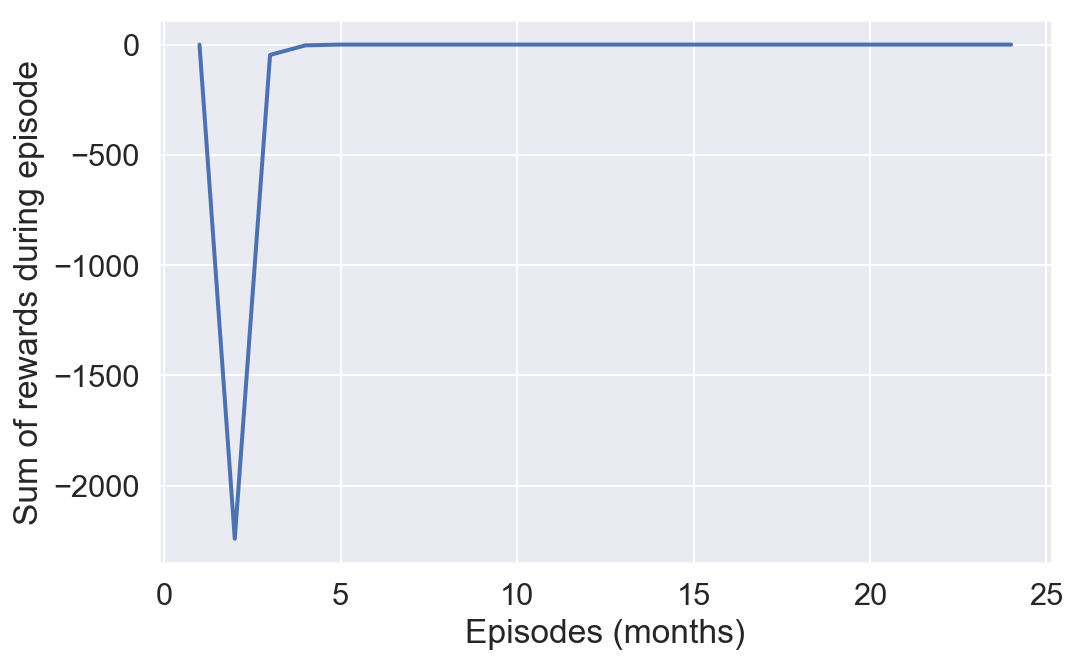

In [13]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, num_episodes+1, 1), np.array(total_reward[:-1]),linewidth=2)
plt.xlabel('Episodes (months)')
plt.ylabel('Sum of rewards during episode')
plt.grid(True)
plt.show()

<font size="3">
Show the temperature simulation results
</font>

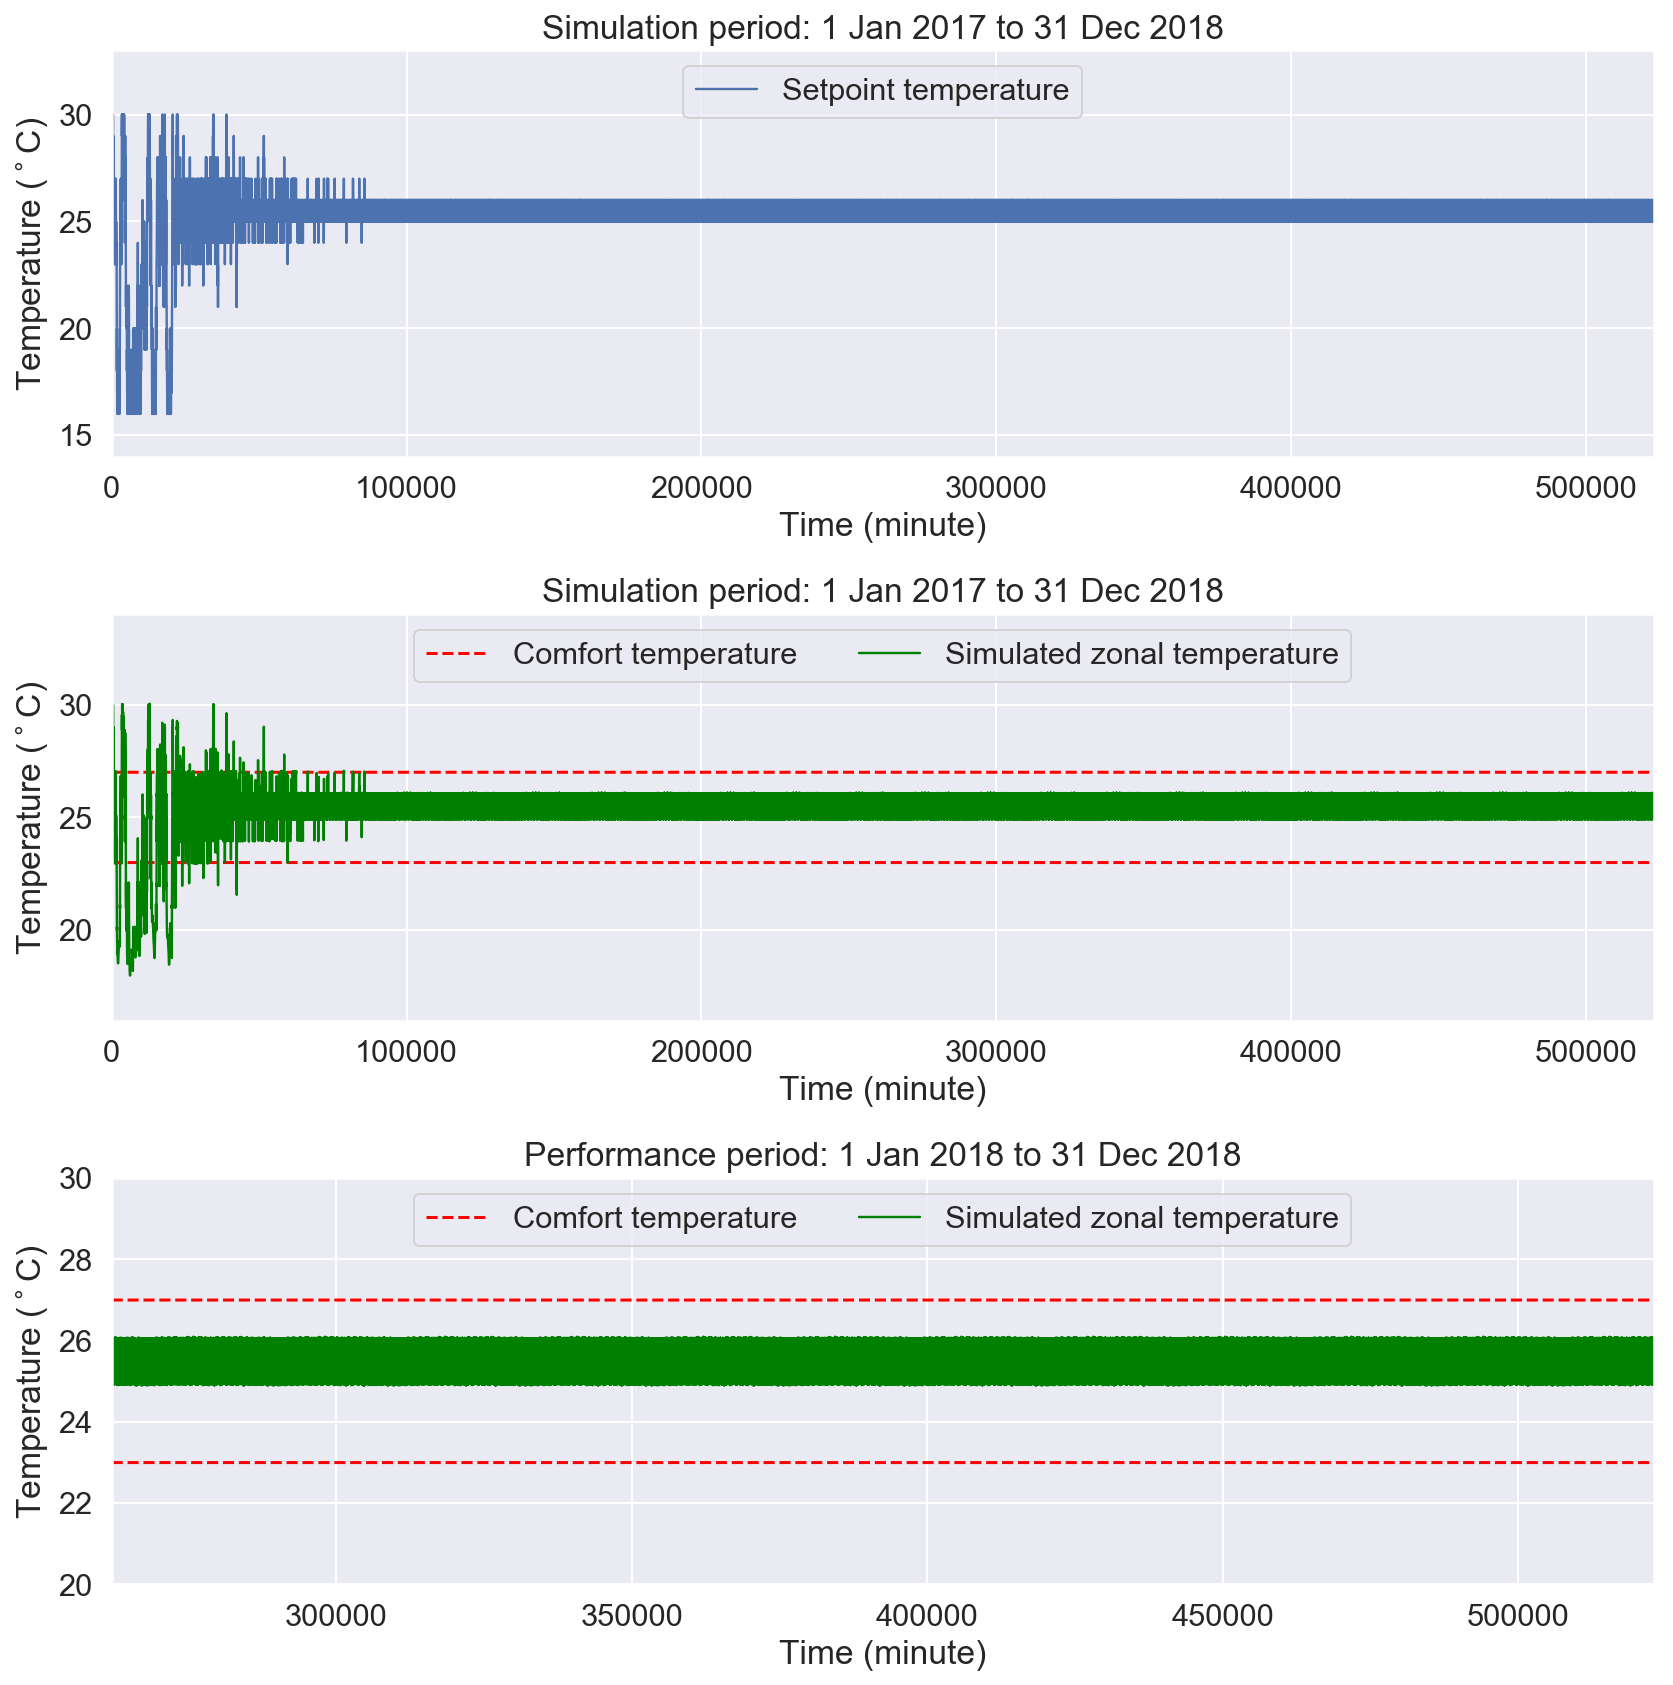

In [14]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12, 12))
 
ax1.plot(df.index, df['Setpoint'], linestyle='-',label='Setpoint temperature',linewidth= 1.2)
ax1.legend(loc='upper center',ncol=4)
ax1.set_xlabel('Time (minute)')
ax1.axis([df.index[0], df.index[-1],14, 33])
ax1.set_ylabel('Temperature ($^\circ$C)')
ax1.set_title('Simulation period: 1 Jan 2017 to 31 Dec 2018', loc='center')
ax1.grid(True)


ax2.plot(df.index, np.repeat(Tupper,len(df.index)), color = 'red', linestyle='--',label='Comfort temperature',linewidth= 1.5) #Temp , Set Temp
ax2.plot(df.index, np.repeat(Tlower,len(df.index)), color = 'red', linestyle='--',linewidth= 1.5)  
ax2.plot(df.index, df['T_continuous'], linestyle='-',label='Simulated zonal temperature',linewidth= 1.2, color = 'green')
ax2.legend(loc='upper center',ncol=4)
ax2.set_xlabel('Time (minute)')
ax2.axis([df.index[0], df.index[-1],16, 34])
ax2.set_ylabel('Temperature ($^\circ$C)')
ax2.set_title('Simulation period: 1 Jan 2017 to 31 Dec 2018', loc='center')
ax2.grid(True)


ax3.plot(df_performance.index, np.repeat(Tupper,len(df_performance.index)), color = 'red', linestyle='--',label='Comfort temperature',linewidth= 1.5) #Temp , Set Temp
ax3.plot(df_performance.index, np.repeat(Tlower,len(df_performance.index)), color = 'red', linestyle='--',linewidth= 1.5)  
ax3.plot(df_performance.index, df_performance['T_continuous'], linestyle='-',label='Simulated zonal temperature',linewidth= 1.2, color = 'green')
ax3.legend(loc='upper center',ncol=4)
ax3.set_xlabel('Time (minute)')
ax3.axis([df_performance.index[0], df_performance.index[-1],20, 30])
ax3.set_ylabel('Temperature ($^\circ$C)')
ax3.set_title('Performance period: 1 Jan 2018 to 31 Dec 2018', loc='center')
ax3.grid(True)

plt.tight_layout()

<font size="3">
Show the number of comfort violation time
</font>

In [15]:
cf = df_performance[(df_performance['T_continuous'] >= env.Tupper) | (df_performance['T_continuous'] <= env.Tlower)]
print("Number of comfort vioation time = {} minutes".format(len(cf)))

Number of comfort vioation time = 0 minutes


<font size="3">
Calulate the energy saving
</font>

In [16]:
power_baseline = df_performance['Baseline'].sum()
energy_baseline = power_baseline*(1/60)
power_usage = df_performance['P'].sum()
energy_usage = power_usage*(1/60)
saving = ((energy_baseline-energy_usage)/energy_baseline)*100
print("Energy saving = {:.2f} %".format(saving))
df_saving = pd.DataFrame(data={'Energy consumption': [energy_baseline.round(2),energy_usage.round(2)], 'index':['Baseline','Simulated']})

Energy saving = 15.85 %


<font size="3">
Show the other simulation results
</font>

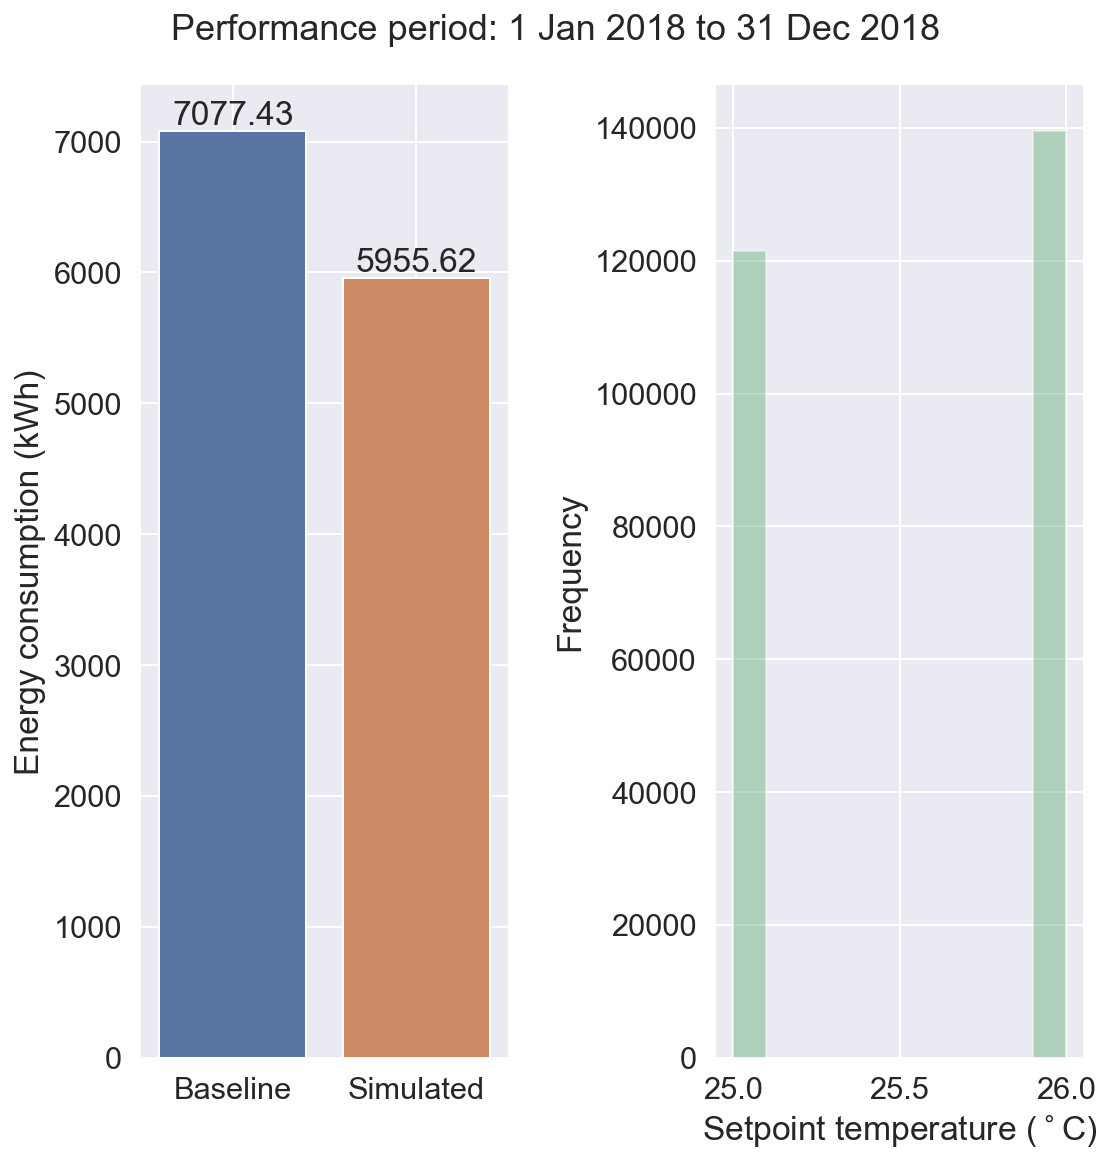

In [17]:
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(8,8))
f.suptitle("Performance period: 1 Jan 2018 to 31 Dec 2018", size=18, y=1.02)
sns.despine(left=True)

x=[i for i in range(0,2)]
y = list(df_saving['Energy consumption'])
sns.barplot(x='index', y="Energy consumption", data=df_saving, ax=ax1)
xlocs=[i+1 for i in range(0,2)]
xlabs=[i/2 for i in range(0,2)]
for i, v in enumerate(y):
    ax1.text(xlocs[i]-1.33 , v+50, str(v))    
ax1.set_xlabel('')
ax1.set_ylabel('Energy consumption (kWh)')
ax1.grid(True)

sns.distplot(df_performance['Setpoint'], color="C2",ax=ax2, kde=False, bins=10)
ax2.set_xlabel('Setpoint temperature ($^\circ$C)')
ax2.set_ylabel('Frequency')
ax2.grid(True)

plt.tight_layout()